**Table of Contents**
<div id="toc"></div>

# Log


# Imports

In [37]:
import os.path
from math import isnan

import pandas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import container
# from matplotlib.lines import Line2D

from person import Person
from visit import Visit

# from model import create_vae

import tensorflow as tf
from keras import backend as K
from keras.layers import LSTM, Input, RepeatVector
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives

# Constants

In [2]:
# Number of visits to be used in the model
NR_VISITS = 4

# currently read vars from each enroll visit
fields_enroll = ['subjid', 'seq', 'visit', 'age', 'hdcat', 'motscore', 'miscore', 'tfcscore', 'fascore', 'fiscore',
                 'sdmt1', 'sdmt2', 'sit1', 'sit2', 'sit3', 'depscore', 'irascore', 'psyscore', 'aptscore', 'exfscore']

# currently read vars from each profile
fields_profile = ['subjid', 'sex', 'region', 'race', 'hxsid', 'caghigh', 'caglow', 'momhd', 'momagesx', 'dadhd',
                  'dadagesx', 'fhx']

# participation file

fields_participation = ['subjid', 'hdcat_0', 'hdcat_l', 'age_0']


# current vars used in the model
_vars = ['caglow', 'caghigh', 'tfcscore', 'motscore', 'age']
#, 'fascore', 'depscore', 'sdmt1'] 

# Profile plot generation (def)

In [3]:
def generate_profile_plots():
    print("not done")
        # Some plots #

    # Sex distribution by group:
#   sex_count = np.zeros(shape=(2, 3))

#   for i in persons:
#       if i.state == 3:
#           j = 2
#       elif i.state == 2:
#           j = 1
#       elif i.state in [4,5]:
#           j = 0
#       if i.sex == 0:
#           sex_count[0, j] += 1
#       elif i.sex == 1:
#           sex_count[1, j] += 1
#       else:
#           print("Sex NA")
    hist_control=[]
    hist_pre = []
    hist_post = []
    
    
    for i in persons:
        j=int(i.caghigh)
        if i.state ==2:
            hist_pre.append(j)
        elif i.state ==3:
            hist_post.append(j)
        elif i.state in [4,5]:
            hist_control.append(j)
    
    
 #   plt.hist(hist_control, bins=[i for i in range(10,72)], facecolor='blue', alpha=0.75, rwidth=0.25)
 #   plt.hist(hist_pre, bins=[i for i in range(10,72)], facecolor='yellow', alpha=0.75, rwidth=0.25)
 #   plt.hist(hist_post, bins=[i for i in range(10,72)], facecolor='red', alpha=0.75, rwidth=0.25)
#plt.show()
    fig1, axs1 = plt.subplots(1,3, figsize=(20, 10), sharex='col')
    axs1[0].hist(hist_control, bins=[i for i in range(10,72)], facecolor='blue', alpha=0.75, rwidth=0.5)
    axs1[1].hist(hist_pre, bins=[i for i in range(10,72)], facecolor='yellow', alpha=0.75, rwidth=0.5)
    axs1[2].hist(hist_post, bins=[i for i in range(10,72)], facecolor='red', alpha=0.75, rwidth=0.5)
    #axs1[0].set_xticks(np.arange(10,72),4)
    axs1[0].yaxis.grid()
    axs1[1].yaxis.grid()
    axs1[2].yaxis.grid()
    

# _vars plot generation (def)

generate_vars_plots(): Generates some plots for the variables used in the model. The plots are the mean and std and a scatter plot showing where the data is distributed along each visit. Blue for Controls, Yellow for Pre-Manifest and Red for Post-Manifest.

In [4]:
def generate_vars_plots():

    def autolabel():
        # Attach a text label next to each value to display its value (only used for mean atm)
        
        for i in ind:
            axs1[0].text(i + 0.24*width, mean[i, _index] + axs1[0].get_yaxis().get_tick_padding()*0.2, '%f' % mean[i, _index], fontsize=15)
            axs1[0].text(i + 1.04*width, mean_pre[i, _index] + axs1[0].get_yaxis().get_tick_padding()*0.2, '%f' % mean_pre[i, _index], fontsize=15)
            axs1[0].text(i + 1.84*width, mean_post[i, _index] + axs1[0].get_yaxis().get_tick_padding()*0.2, '%f' % mean_post[i, _index], fontsize=15)

    for var in _vars:
        _index = _vars.index(var)
        ind = np.arange(NR_VISITS)
        width = 0.30
        fig1, axs1 = plt.subplots(2, 1, figsize=(20, 10), sharex='col')
        fig1.suptitle(var, fontsize=16)
        
        rects_1 = axs1[0].errorbar(ind + 0.2*width, mean[:, _index], std[:, _index], color='b', linestyle='None', marker='o', capsize=2, label="Control")
        rects_2 = axs1[0].errorbar(ind + width, mean_pre[:, _index], std_pre[:, _index], color='y', linestyle='None', marker='o', capsize=2, label="Pre")
        rects_3 = axs1[0].errorbar(ind + (1.8*width), mean_post[:, _index], std_post[:, _index], color='r',
                                   linestyle='None', marker='o', capsize=2, label="Post")
        
        axs1[0].set_ylabel('Value')
        axs1[0].set_title("Mean and std")
        axs1[0].set_xticks(ind + width)
        start, end = axs1[0].get_ylim()
        axs1[0].set_yticks(np.arange(round(start)-1, round(end)+1, round((end-start)/10)))
        axs1[0].grid(linestyle='--', alpha=0.7)
        autolabel()

        # Remove std drawing from the legend
        handles, labels = axs1[0].get_legend_handles_labels()
        new_handles = []

        for h in handles:
            # only need to edit the errorbar legend entries
            if isinstance(h, container.ErrorbarContainer):
                new_handles.append(h[0])
            else:
                new_handles.append(h)

        fig1.legend(new_handles, labels, loc='center right')
        fig1.subplots_adjust(hspace=0.15)

        # Scatter Plot #
        
        axs1[1].set_ylabel('Value')
        axs1[1].set_xlabel('Visit Number')
        axs1[1].set_title("Scatter plot")
        axs1[1].set_xticks(ind + width)
        axs1[1].set_xticklabels(np.arange(1,NR_VISITS+1))

        # create x values for all the Y values with random to distribute them along the visit's width
        for z in ind:
            _x1 = np.ones(control_data.shape[0])*(z + 0.2*width) + (np.random.uniform(-1.0, 1.0, control_data.shape[0]) * width/3)
            axs1[1].scatter(_x1, control_data[:, z, _index], facecolors='none', edgecolor='b', s=5)
            
            _x2 = np.ones(pre_data.shape[0])*(z + width) + (np.random.uniform(-1.0, 1.0, pre_data.shape[0]) * width/3)
            axs1[1].scatter(_x2, pre_data[:, z, _index], facecolors='none', edgecolor='y', s=5)
            
            _x3 = np.ones(post_data.shape[0])*(z + 1.8*width) + (np.random.uniform(-1.0, 1.0, post_data.shape[0]) * width/3)
            axs1[1].scatter(_x3, post_data[:, z, _index], facecolors='none', edgecolor='r', s=5)
            
        start, end = axs1[1].get_ylim()
        axs1[1].set_yticks(np.arange(round(start)-1, round(end)+1, round((end-start)/10)))
        axs1[1].grid(linestyle='--', alpha=0.7)

    plt.show()

# Prediction plot generation (def)

In [5]:
    # Plots after prediction
    
    def generate_pred_plots():
        
        n_plots = NR_VISITS
        #print(n_plots)
        n_cols = n_plots // 2
        #print(n_cols)
        n_rows = n_plots // n_cols
        #print(n_rows)
        n_rows += n_plots % n_cols
        #print(n_rows)
        position = np.arange(1, n_plots +1)
        
        for var in _vars:
            _index = _vars.index(var)
            fig = plt.figure(1, figsize=(20,10))
            fig.suptitle(var, fontsize=16)
            for i in range(NR_VISITS):
                ax = fig.add_subplot(n_rows, n_cols, position[i])
                ax.plot(control_data[:, i, _index], 'ro', mfc='none', label='data')
                ax.plot(preds[:, i, _index], 'bo', mfc='none', label='predict')
                ax.legend(loc='upper right')
                ax.set_title("Visit %d" % (i+1))
            
            plt.show()
                

# Get Data

Get the data from the DB

In [6]:
    pre = 0
    post = 0
    control = 0

    nr_vis_ok = {}
    nr_vis = {}

    list_visits = []
    list_pre = []
    list_post = []
    list_control = []

    if os.path.exists('Data/enroll.csv'):
        df = pandas.read_csv('Data/enroll.csv', dtype={"age": str}, usecols=fields_enroll)
        #print(df)
    else:
        print("no file - enroll.csv")

    if os.path.exists('Data/profile.csv'):
        df_p = pandas.read_csv('Data/profile.csv', delimiter='\t', usecols=fields_profile)
        #print(df_p)
    else:
        print("no file - profile.csv")
        
    if os.path.exists('Data/participation.csv'):
        df_part = pandas.read_csv('Data/participation.csv', delimiter='\t', usecols=fields_participation)
    else:
        print("no file - participation.csv")
    
        
    subjids = {}
    persons = []
    count = 0
    df2 = df.values
    df2_p = df_p.values

    for index, i in enumerate(df['subjid']):

        seq = df2[index, 1]
        visit = df2[index, 2]
        age = df2[index, 3] if df2[index, 3] != '<18' else '17'
        if isnan(df2[index,4]) and df2[index,2] != 'Phone Contact':
            print("NAN")
        hdcat = df2[index, 4]
        motscore = df2[index, 5]
        miscore = df2[index, 6]
        tfcscore = df2[index, 7]
        fascore = df2[index, 8]
        fiscore = df2[index, 9]
        sdmt1 = df2[index, 10]
        sdmt2 = df2[index, 11]
        sit1 = df2[index, 12]
        sit2 = df2[index, 13]
        sit3 = df2[index, 14]
        depscore = df2[index, 15]
        irascore = df2[index, 16]
        psyscore = df2[index, 17]
        aptscore = df2[index, 18]
        exfscore = df2[index, 19]
        

        # New ENROLL visit data (selected)

        new_visit = Visit(seq, age, visit, hdcat, motscore, miscore, tfcscore, fascore, fiscore, sdmt1, sdmt2, sit1,
                          sit2, sit3, depscore, irascore, psyscore, aptscore, exfscore)

        if i not in subjids:
            # New person

            persons.append(Person(i))
            persons[count].add_visit(new_visit)

            # Count Baseline and FUP only
            if new_visit.visit in ['Baseline', 'Follow Up']:
                persons[count].state = hdcat
                persons[count].visits_ok += 1

            # Index in persons array
            count += 1

            # Total visit count
            subjids[i] = 1

        else:
            # Increase counters and add new visit
            subjids[i] += 1
            persons[count-1].add_visit(new_visit)
            if new_visit.visit in ['Baseline', 'Follow Up']:
                persons[count-1].state = hdcat
                persons[count-1].visits_ok += 1
    
    # counters  for each of the 3 groups
    for i in persons:
        if i.state == 2:
            pre += 1
        elif i.state == 3:
            post += 1
        elif i.state in [4,5]:
            control += 1

        if i.visits_ok not in nr_vis_ok:
            nr_vis_ok[i.visits_ok] = 1
        else:
            nr_vis_ok[i.visits_ok] += 1
        if i.visits not in nr_vis:
            nr_vis[i.visits] = 1
        else:
            nr_vis[i.visits] += 1

        if i.visits_ok == NR_VISITS:
            # Persons with visits total = visits baseline + FUP desired
            list_visits.append(i)
            # Separated by control, pre-manifest, and post-manifest
            if i.state == 2:
                list_pre.append(i)
            elif i.state == 3:
                list_post.append(i)
            elif i.state in [4,5]:
                list_control.append(i)
        if i.visits_ok > NR_VISITS:
            for x in range(i.visits_ok - NR_VISITS +1):
                if i.visit_list[x].visit in ['Baseline', 'Follow Up'] and i.visit_list[x+1].visit == 'Follow Up' and \
                i.visit_list[x+2].visit == 'Follow Up' and i.visit_list[x+3].visit == 'Follow Up':
                    list_visits.append(i)
                    if i.state==2:
                        list_pre.append(i)
                    elif i.state == 3:
                        list_post.append(i)
                    elif i.state in [4,5]:
                        list_control.append(i)
                    # only add the first NR_VISITS good, in case there are more combinations
                    break
            

    for index, i in enumerate(df_p['subjid']):
        region = df2_p[index, 1]
        sex = df2_p[index, 2]
        race = df2_p[index, 3]
        hxsid = df2_p[index, 4]
        caghigh = df2_p[index, 5] if df2_p[index, 5] != ">70" else '71'
        caglow = df2_p[index, 6] if df2_p[index, 6] != ">28" else '29'
        momhd = df2_p[index, 7]
        momagesx = df2_p[index, 8]
        dadhd = df2_p[index, 9]
        dadagesx = df2_p[index, 10]
        fhx = df2_p[index, 11]

        persons[index].add_info(region, sex, race, hxsid, caghigh, caglow, momhd, momagesx, dadhd, dadagesx, fhx)

    # Data #
    
    #Info#
    pre_caghigh=0
    pre_caglow=0
    pre_bothcag=0
    pre_underage=0
    post_caghigh=0
    post_caglow=0
    post_bothcag=0
    post_underage=0
    control_caghigh=0
    control_caglow=0
    control_bothcag =0
    control_underage =0
    
    for p in persons:
        if p.state == 2:
            #pre
            if p.visit_list[0].age == '17':
                pre_underage +=1
            if  p.caghigh == '71' and p.caglow == '29':
                pre_bothcag +=1
            else:
                if p.caghigh == '71':
                    pre_caghigh +=1
                if p.caglow == '29':
                    pre_caglow +=1
        elif p.state == 3:
            #post
            if p.visit_list[0].age == '17':
                post_underage +=1
            if  p.caghigh == '71' and p.caglow == '29':
                pre_bothcag +=1
            else:
                if p.caghigh == '71':
                    post_caghigh +=1
                if p.caglow == '29':
                    post_caglow +=1
        elif p.state in [4,5]:
            #control
            if p.visit_list[0].age == '17':
                control_underage +=1
            if  p.caghigh == '71' and p.caglow == '29':
                control_bothcag +=1
            else:
                if p.caghigh == '71':
                    control_caghigh +=1
                if p.caglow == '29':
                    control_caglow +=1
    
    print("From total data: %d controls, %d Pre, %d post: \n" % (control, pre, post))
    print("Controls: caghigh - %d    caglow - %d  both - %d" % (control_caghigh, control_caglow, control_bothcag))
    print("Pre: caghigh - %d    caglow - %d both - %d" % (pre_caghigh, pre_caglow, pre_bothcag))
    print("Post: caghigh - %d    caglow - %d  both - %d" % (post_caghigh, post_caglow, post_bothcag))
    print("Underage: Control %d ; Pre %d ; Post %d \n" % (control_underage, pre_underage, post_underage))
    
    pre_caghigh=0
    pre_caglow=0
    pre_bothcag=0
    pre_underage=0
    post_caghigh=0
    post_caglow=0
    post_bothcag=0
    post_underage=0
    control_caghigh=0
    control_caglow=0
    control_bothcag =0
    control_underage =0
    
    for p in list_visits:
        if p.state == 2:
            #pre
            if p.visit_list[0].age == '17':
                pre_underage +=1
            if  p.caghigh == '71' and p.caglow == '29':
                pre_bothcag +=1
            else:
                if p.caghigh == '71':
                    pre_caghigh +=1
                if p.caglow == '29':
                    pre_caglow +=1
        elif p.state == 3:
            #post
            if p.visit_list[0].age == '17':
                post_underage +=1
            if  p.caghigh == '71' and p.caglow == '29':
                pre_bothcag +=1
            else:
                if p.caghigh == '71':
                    post_caghigh +=1
                if p.caglow == '29':
                    post_caglow +=1
        elif p.state in [4,5]:
            #control
            if p.visit_list[0].age == '17':
                control_underage +=1
            if  p.caghigh == '71' and p.caglow == '29':
                control_bothcag +=1
            else:
                if p.caghigh == '71':
                    control_caghigh +=1
                if p.caglow == '29':
                    control_caglow +=1
    
    
    print("From data to be used: %d controls, %d Pre, %d post: \n" % (len(list_control),  len(list_pre), len(list_post)))
    print("Controls: caghigh - %d    caglow - %d  both - %d" % (control_caghigh, control_caglow, control_bothcag))
    print("Pre: caghigh - %d    caglow - %d both - %d" % (pre_caghigh, pre_caglow, pre_bothcag))
    print("Post: caghigh - %d    caglow - %d  both - %d" % (post_caghigh, post_caglow, post_bothcag))
    print("Underage: Control %d ; Pre %d ; Post %d \n" % (control_underage, pre_underage, post_underage))

    # For the model #
    
    control_data = np.zeros(shape=(len(list_control), NR_VISITS, len(_vars)))
    pre_data = np.zeros(shape=(len(list_pre), NR_VISITS, len(_vars)))
    post_data = np.zeros(shape=(len(list_post), NR_VISITS, len(_vars)))

    control_labels = np.chararray(shape=(len(list_control), 1))
    pre_labels = np.chararray(shape=(len(list_pre), 1))
    post_labels = np.chararray(shape=(len(list_post), 1))

    for index, i in enumerate(list_control):
        c = 0
        for index2, j in enumerate(i.visit_list):
            if j.visit != "Phone Contact":
                control_data[index, c, 0] = i.caglow
                control_data[index, c, 1] = i.caghigh
                control_data[index, c, 2] = j.tfcscore
                control_data[index, c, 3] = j.motscore if j.motscore == j.motscore else j.miscore
                control_data[index, c, 4] = j.age 
             # control_data[index, c, 5] = j.fascore if j.fascore == j.fascore else j.fiscore
             # control_data[index, c, 6] = j.depscore
             # control_data[index, c, 7] = j.sdmt1
                
                c += 1
                if c == NR_VISITS:
                    #Most up-to-date hdcat
                    i.state = j.hdcat
                    break
        control_labels[index] = i.subjid

    for index, i in enumerate(list_pre):
        c = 0
        for index2, j in enumerate(i.visit_list):
            if j.visit != "Phone Contact":
                pre_data[index, c, 0] = i.caglow
                pre_data[index, c, 1] = i.caghigh 
                pre_data[index, c, 2] = j.tfcscore
                pre_data[index, c, 3] = j.motscore if j.motscore == j.motscore else j.miscore
                pre_data[index, c, 4] = j.age
                #pre_data[index, c, 5] = j.fascore if j.fascore == j.fascore else j.fiscore
                #pre_data[index, c, 6] = j.depscore
                #pre_data[index, c, 7] = j.sdmt1
                c += 1
                if c == NR_VISITS:
                     #Most up-to-date hdcat
                    i.state = j.hdcat
                    break
        pre_labels[index] = i.subjid

    for index, i in enumerate(list_post):
        c = 0
        for index2, j in enumerate(i.visit_list):
            if j.visit != "Phone Contact":
                post_data[index, c, 0] = i.caglow 
                post_data[index, c, 1] = i.caghigh
                post_data[index, c, 2] = j.tfcscore
                post_data[index, c, 3] = j.motscore if j.motscore == j.motscore else j.miscore
                post_data[index, c, 4] = j.age
               #post_data[index, c, 5] = j.fascore if j.fascore == j.fascore else j.fiscore
               #post_data[index, c, 6] = j.depscore
               #post_data[index, c, 7] = j.sdmt1
                c += 1
                if c == NR_VISITS:
                     #Most up-to-date hdcat
                    i.state = j.hdcat
                    break
        post_labels[index] = i.subjid

    control_data = control_data.astype('float32')
    pre_data = pre_data.astype('float32')
    post_data = post_data.astype('float32')

    # Entries to be removed from the used data - ones with nan values on the required fields or missing/wrong 999* and outliers -> age =17,
    # caghigh = 71, caglow = 29 
    
    print("Removing the unwanted data from controls \n")
    to_del = []
    
    for index, x1 in np.ndenumerate(control_data):
        if isnan(x1) or x1 in [9999,9998,9997,9996] or (x1 == 71 and index[2] == 1) or (x1 == 29 and index[2] == 0) or (x1 == 17 and index[2]==4):
            if index[0] not in to_del:
                to_del.append(index[0])
                
    print("Removing %d entries from control data" % len(to_del))
    print("Old control -> %s" % (control_data.shape,))
    control_data = np.delete(control_data, to_del, 0)
    control_labels = np.delete(control_labels, to_del, 0)
    print("New control -> %s\n" % (control_data.shape,))
    
    print("Removing the unwanted data from pre \n")
    to_del = []
    for index, x1 in np.ndenumerate(pre_data):
        if isnan(x1) or x1 in [9999,9998,9997,9996] or (x1 == 71 and index[2] == 1) or (x1 == 29 and index[2] == 0) or (x1 == 17 and index[2]==4):
            if index[0] not in to_del:
                to_del.append(index[0])
    
    print("Removing %d entries from pre data" % len(to_del))
    print("Old pre -> %s" % (pre_data.shape,))
    pre_data = np.delete(pre_data, to_del, 0)
    pre_labels = np.delete(pre_labels, to_del, 0)
    print("New pre -> %s\n" % (pre_data.shape,))
    
    print("Removing the unwanted data from post \n")
    
    to_del = []
    for index, x1 in np.ndenumerate(post_data):
        if isnan(x1) or x1 in [9999,9998,9997,9996] or (x1 == 71 and index[2] == 1) or (x1 == 29 and index[2] == 0) or (x1 == 17 and index[2]==4):
            if index[0] not in to_del:
                to_del.append(index[0])
                
    print("Removing %d entries from post data" % len(to_del))
    print("Old post -> %s" % (post_data.shape,))
    post_data = np.delete(post_data, to_del, 0)
    post_labels = np.delete(post_labels, to_del, 0)
    print("New post -> %s\n" % (post_data.shape,))
    
    # mean and std #

    std = control_data.std(axis=0)
    mean = control_data.mean(axis=0)

    std_pre = pre_data.std(axis=0)
    mean_pre = pre_data.mean(axis=0)

    std_post = post_data.std(axis=0)
    mean_post = post_data.mean(axis=0)


From total data: 3719 controls, 3187 Pre, 8395 post: 

Controls: caghigh - 0    caglow - 1  both - 0
Pre: caghigh - 0    caglow - 44 both - 0
Post: caghigh - 28    caglow - 163  both - 0
Underage: Control 4 ; Pre 2 ; Post 25 

From data to be used: 713 controls, 598 Pre, 1952 post: 

Controls: caghigh - 0    caglow - 1  both - 0
Pre: caghigh - 0    caglow - 10 both - 0
Post: caghigh - 4    caglow - 39  both - 0
Underage: Control 1 ; Pre 1 ; Post 4 

Removing the unwanted data from controls 

Removing 5 entries from control data
Old control -> (713, 4, 5)
New control -> (708, 4, 5)

Removing the unwanted data from pre 

Removing 22 entries from pre data
Old pre -> (598, 4, 5)
New pre -> (576, 4, 5)

Removing the unwanted data from post 

Removing 67 entries from post data
Old post -> (1952, 4, 5)
New post -> (1885, 4, 5)



not done


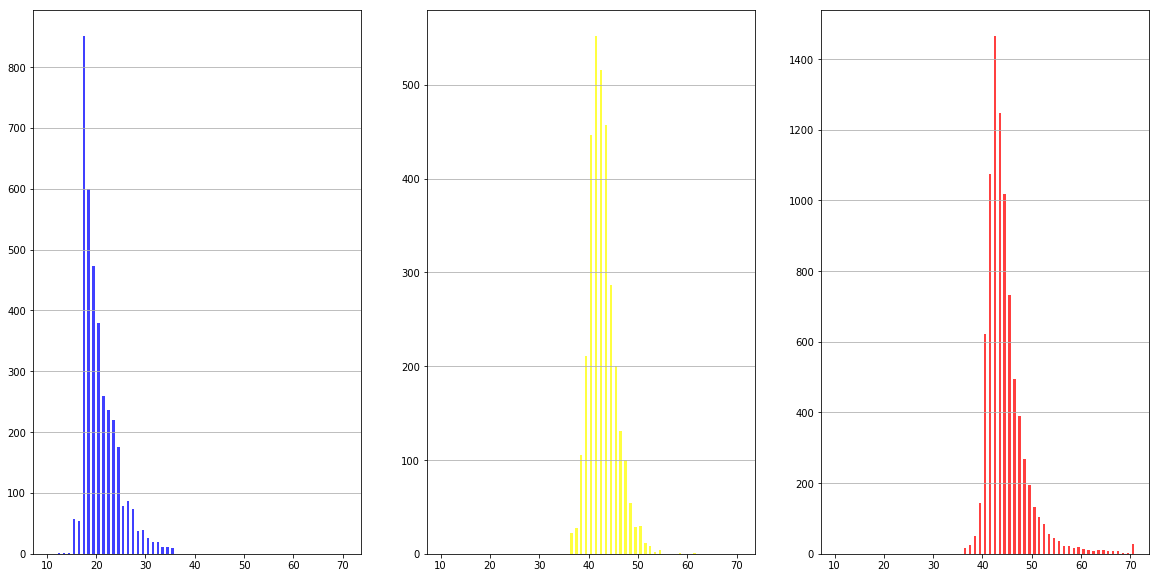

In [7]:
generate_profile_plots()


# Data Info

In [8]:
#df.loc[df['subjid'] == 'R995458444']
#df.loc[df['age'] == '<18'].subjid.unique()
#print(df.loc[(df['hdcat'].isna()) & (df['visit'] != 'Phone Contact')])
#for i in list_control:
  #  if int(i.caghigh) >36 and i.state not in [2,3]:
#        print(i.subjid , i.state , i.caghigh)
#print(df_part)
#print(df_part.shape)
#print(df_p.shape)
#print(df['subjid'].unique().shape)
#for (i,j,k) in zip(list_control, list_pre, list_post):
#    if i.state not in [2,3,4,5]:
#        print("control")
#    elif j.state not in [2,3,4,5]:
#        print("pre")
#    elif k.state not in [2,3,4,5]:
#        print("post")

#print((len(list_control) + len(list_pre) + len(list_post)))
#
#
#for i in list_control:
#    if int(i.caghigh) > 35:
#        print(i.subjid, i.caghigh)
#        
#df.loc[(df['hdcat'] !=2) & (df['hdcat'] !=3) & (df['visit'] != 'Phone Contact')]
#z = df.loc[df['hdcat'] == 5]['subjid'].values
#print(z)

#for i in list_control:
#   if i.subjid == 'R01055300X':
#       print("ok", i.state, i.caghigh)



Generate some info on the data acquired

In [9]:
#print(mean)

# _vars plots

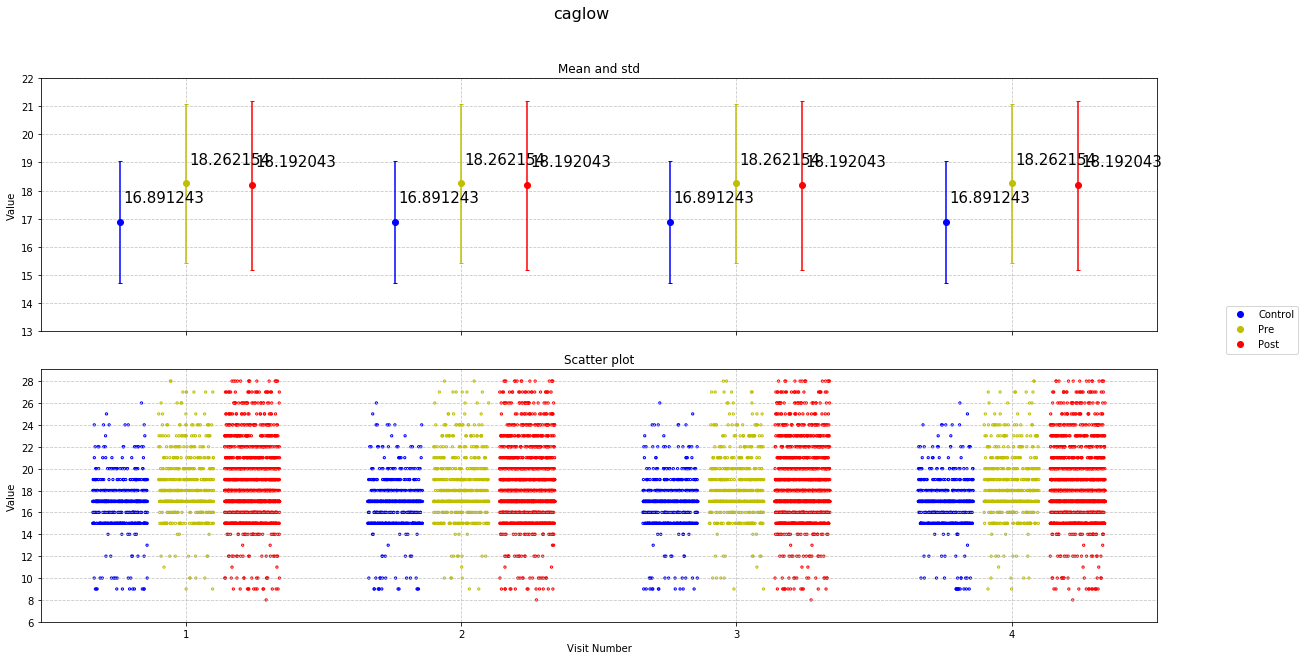

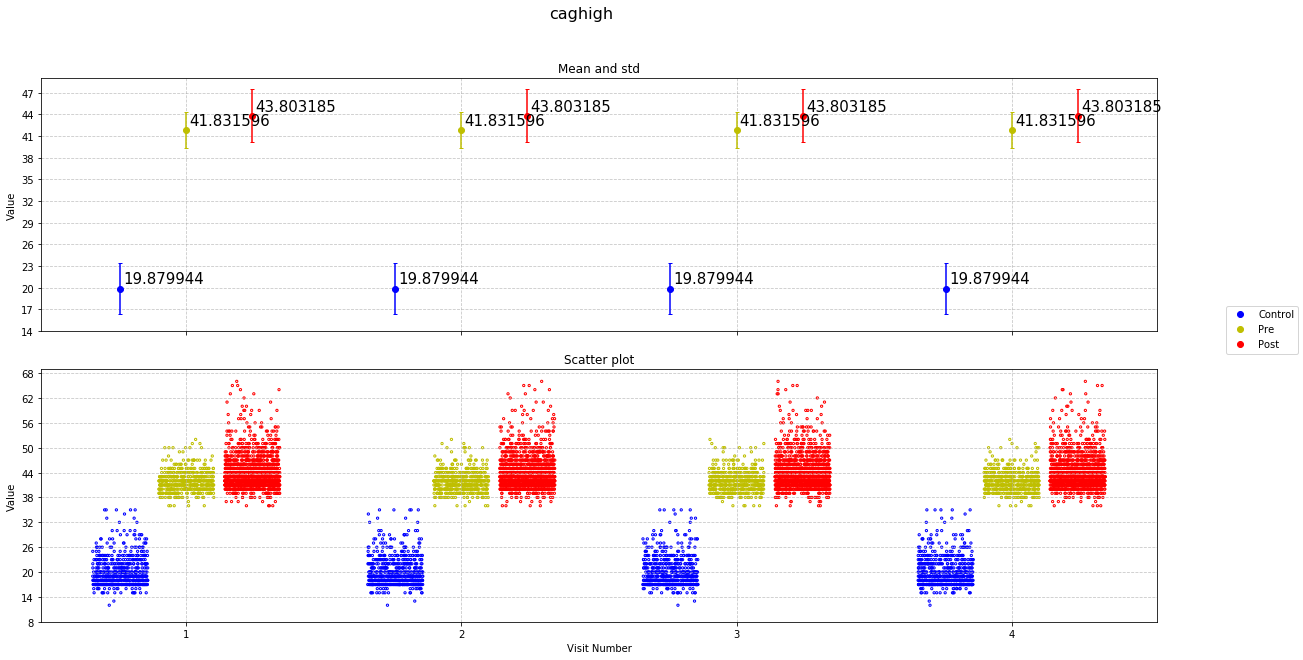

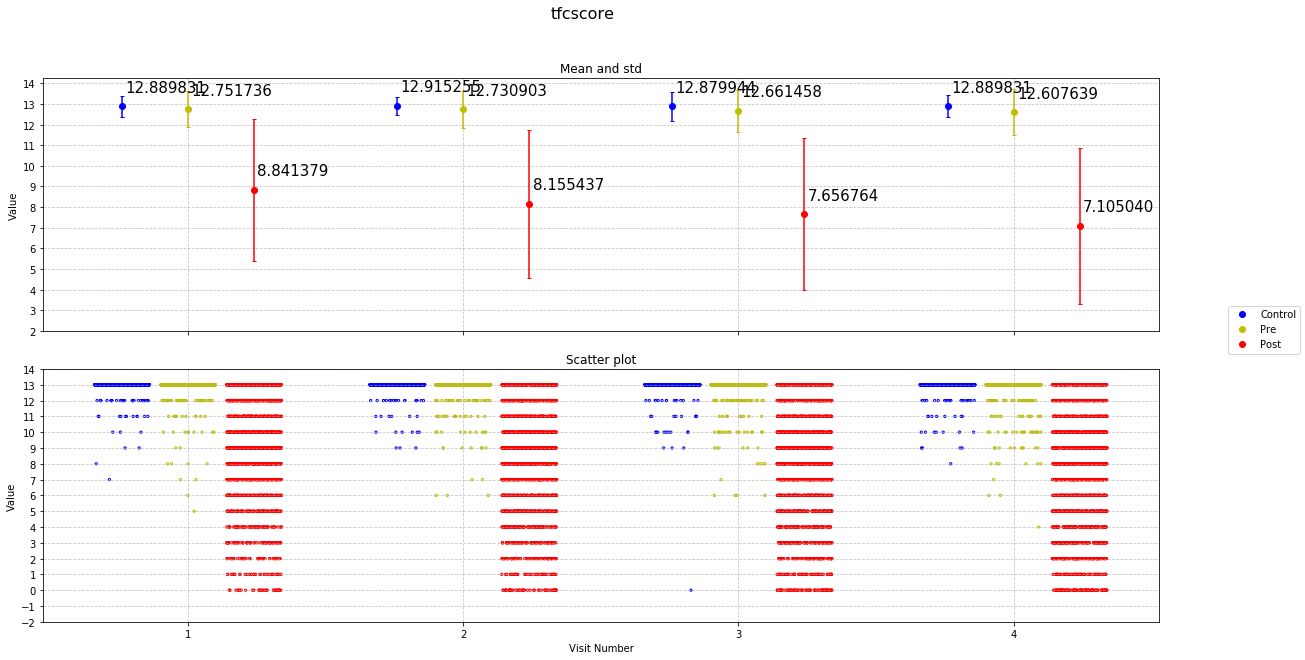

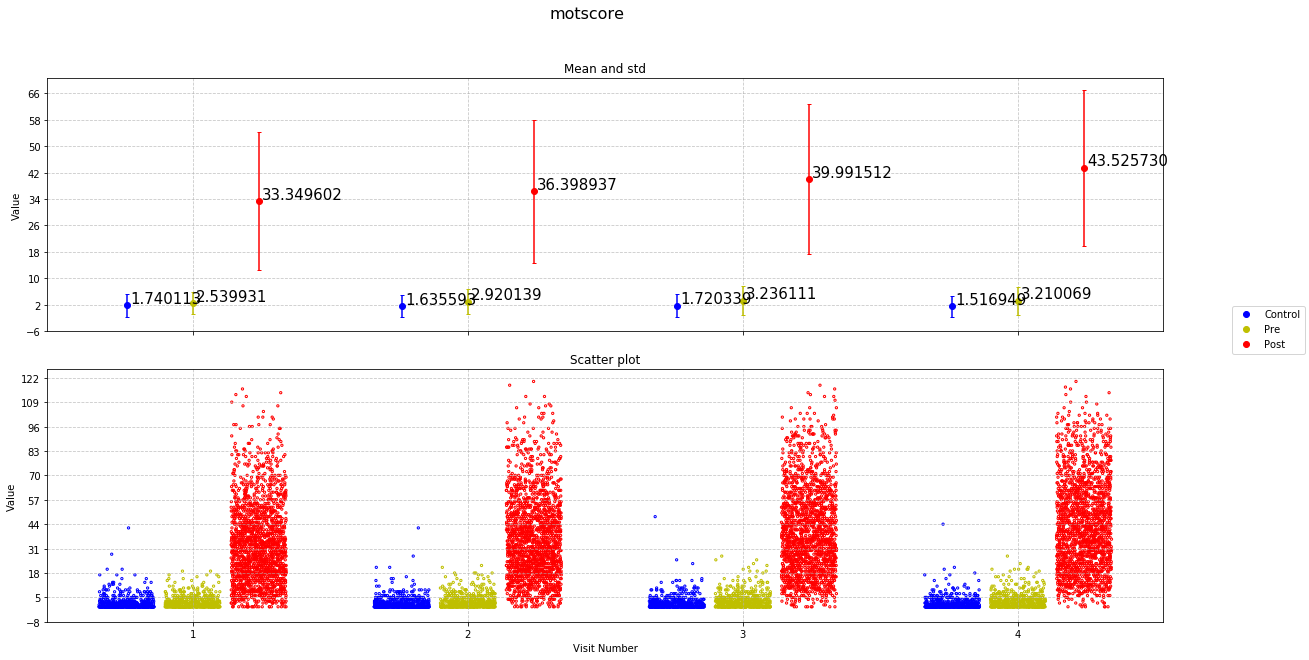

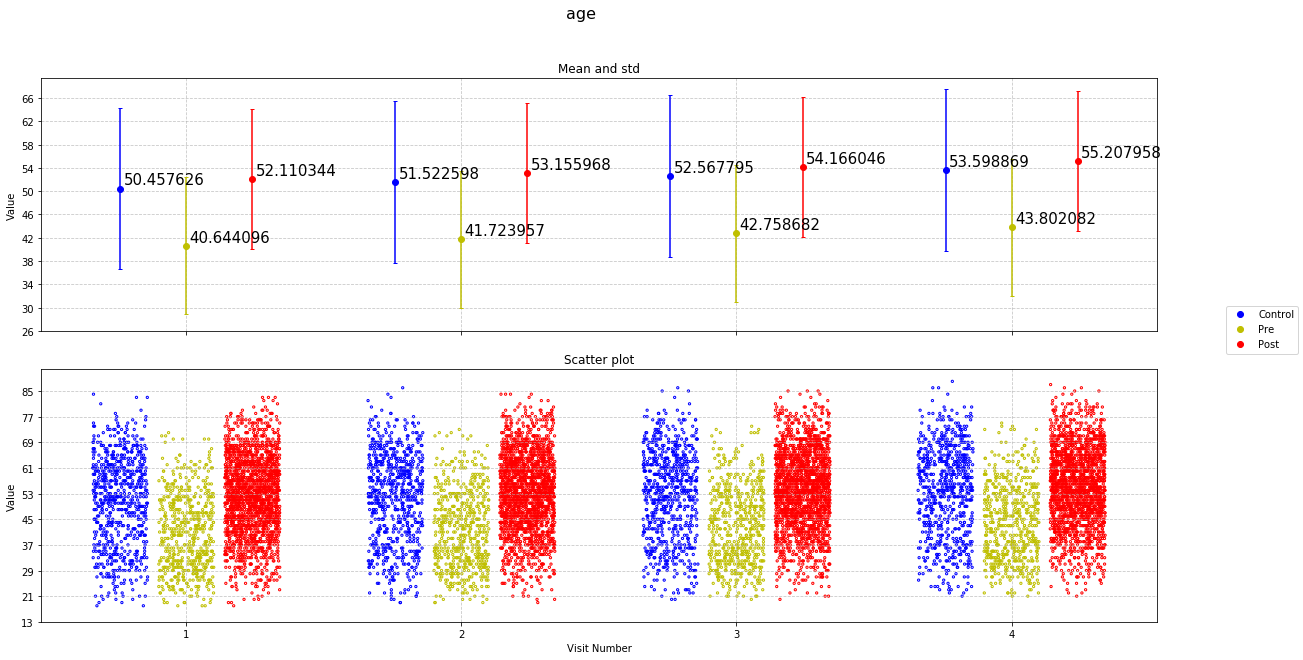

In [10]:
    generate_vars_plots() # caglow and caghigh won't change with time

# Network

## Model definition 

In [35]:
# model #

def create_vae(input_dim, timesteps, batch_size, intermediate_dim, latent_dim, epsilon_std, beta):
    x = Input(shape=(timesteps, input_dim))     # Inputs
    h = LSTM(intermediate_dim)(x)       # LSTM output

    # Latent space
    z_mean = Dense(latent_dim, activation='linear')(h)
    z_log_sigma = Dense(latent_dim, activation='softplus')(h)

    # Sampling

    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_sigma) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

    # decoded LSTM layer

    decoder_h = LSTM(intermediate_dim, return_sequences=True)
    decoder_mean = LSTM(input_dim, return_sequences=True)

    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h(h_decoded)

    x_decoded_mean = decoder_mean(h_decoded)

    # end-to-end autoencoder

    vae = Model(x, x_decoded_mean)

    # encoder: inputs to latent space

    encoder = Model(x, z_mean)

    # generator: from latent space to reconstructed inputs

    decoder_input = Input(shape=(latent_dim, ))

    _h_decoded = RepeatVector(timesteps)(decoder_input)
    _h_decoded = decoder_h(_h_decoded)

    _x_decoded_mean = decoder_mean(_h_decoded)

    generator = Model(decoder_input, _x_decoded_mean)

    def vae_loss(x, x_decoded_mean):
        xent_loss = objectives.mse(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss * beta
        return loss
    run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    vae.compile(optimizer='adam', loss=vae_loss, options=run_opts)

    return vae, encoder, generator

## Running the model

In [12]:
    # Plots after pred #
    def plot_loss(a,b,c):
        fig = plt.figure(1, figsize=(20,10))
        plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label='Training Loss')
        plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title("batch size %d, latent_dim %d, intermediate_dim %d" % (a,b,c))
        start, end = plt.ylim()
        plt.yticks(np.arange(0, 1.1, 0.05))
        plt.grid(linestyle='--', alpha=0.7)
        print("\n Min -> ", min(history.history['loss']))
        plt.show()
        return (min(history.history['loss']), min(history.history['val_loss']))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.40471498599743255


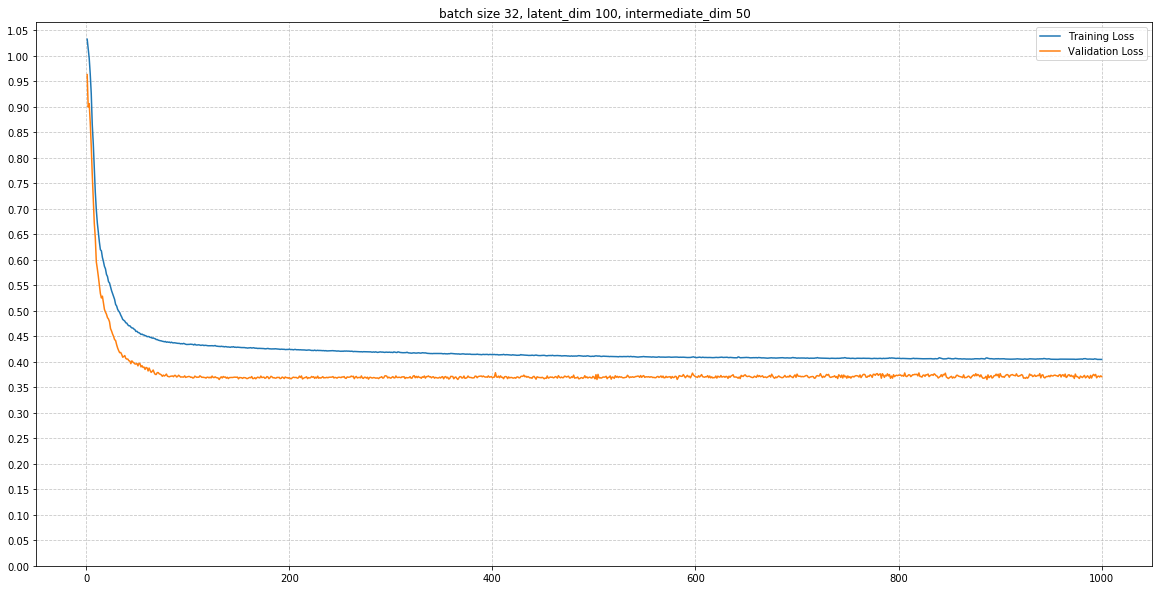

0.40471498599743255 0.3653274027394577
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.4045947472114024


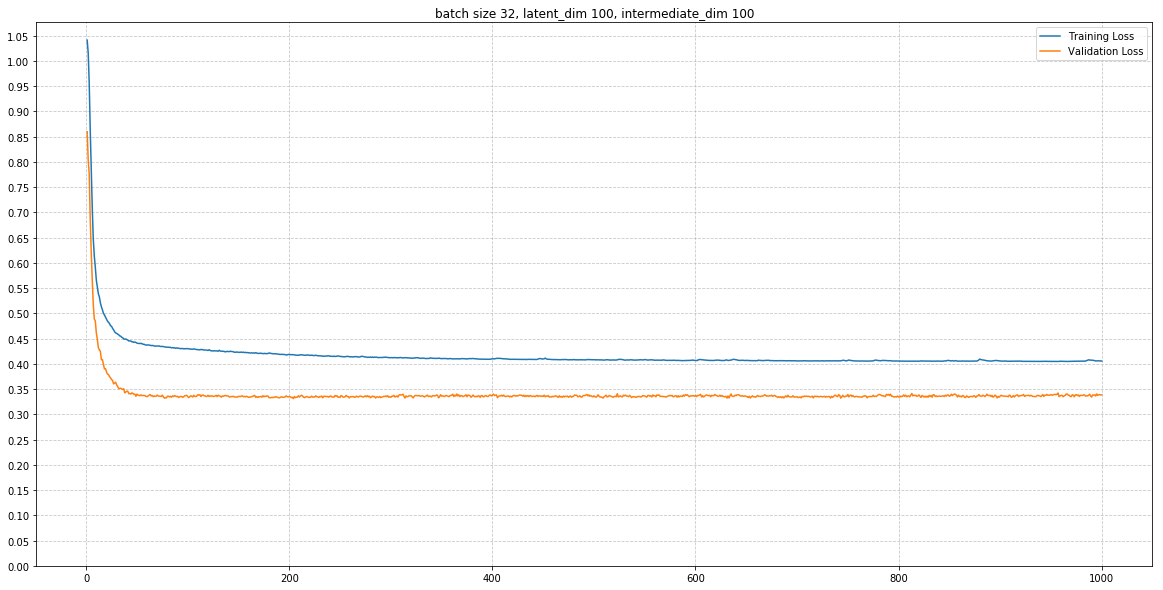

0.4045947472114024 0.33100582428381475
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.37350044949737116


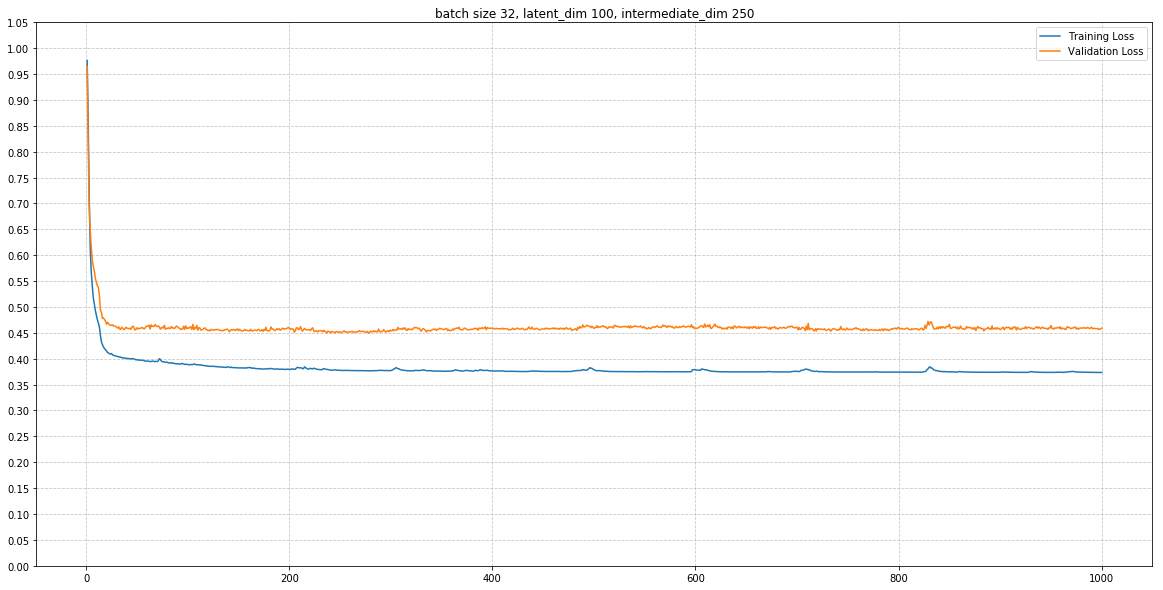

0.37350044949737116 0.4492873209463039
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.38090697815477215


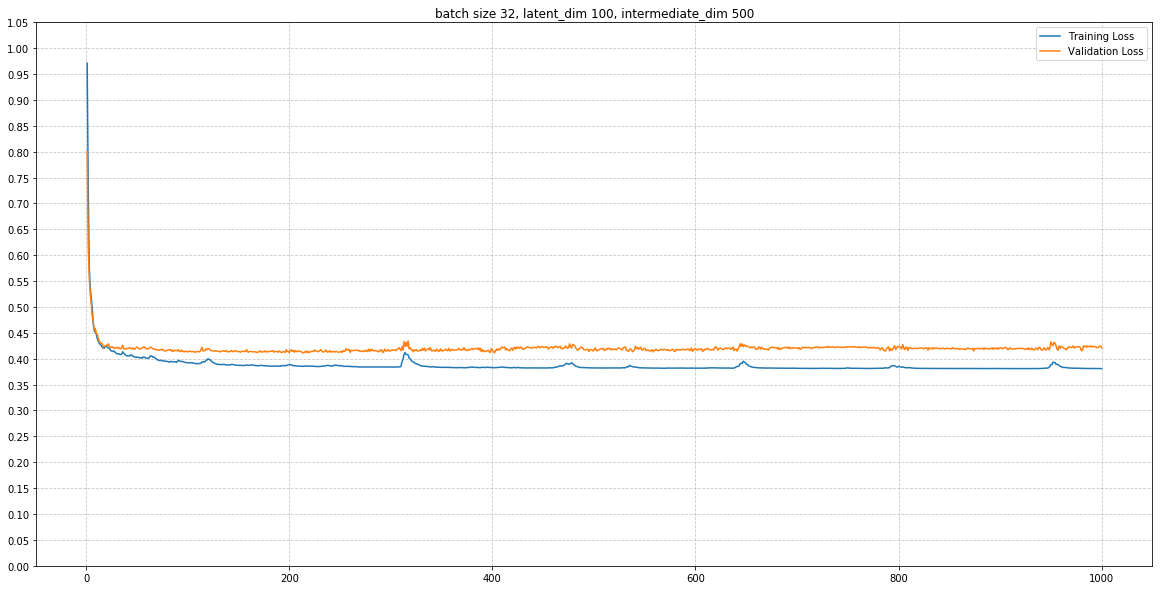

0.38090697815477215 0.41112175541864315
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.37645740449007326


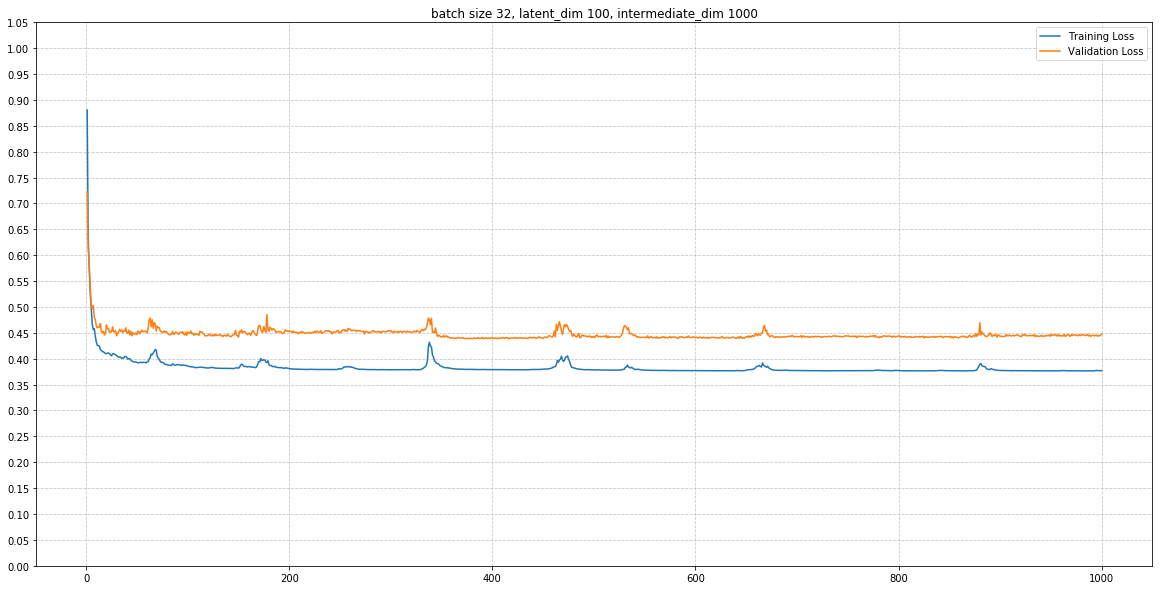

0.37645740449007326 0.43837559810826476
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.41582497975430305


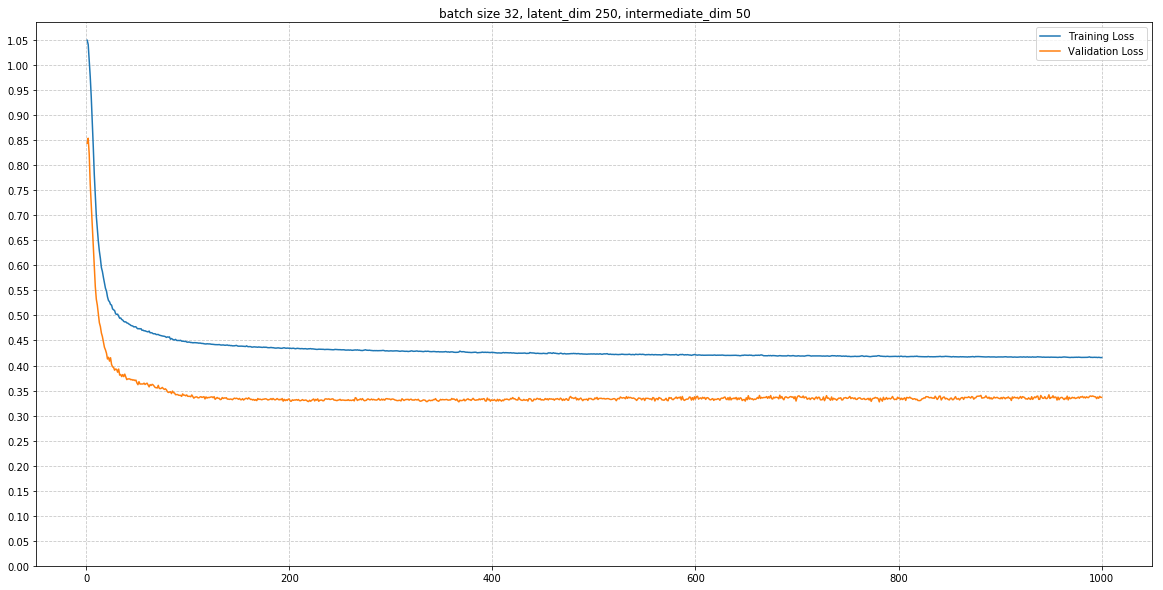

0.41582497975430305 0.3274405827404748
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.42181275532228785


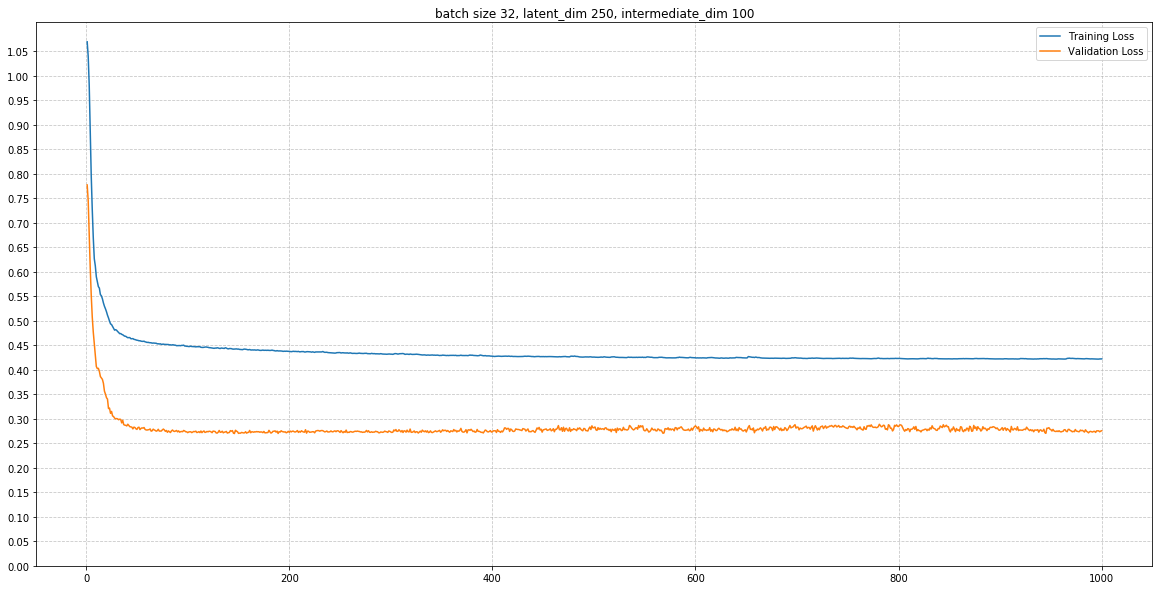

0.42181275532228785 0.269978103503375
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.33352650807308226


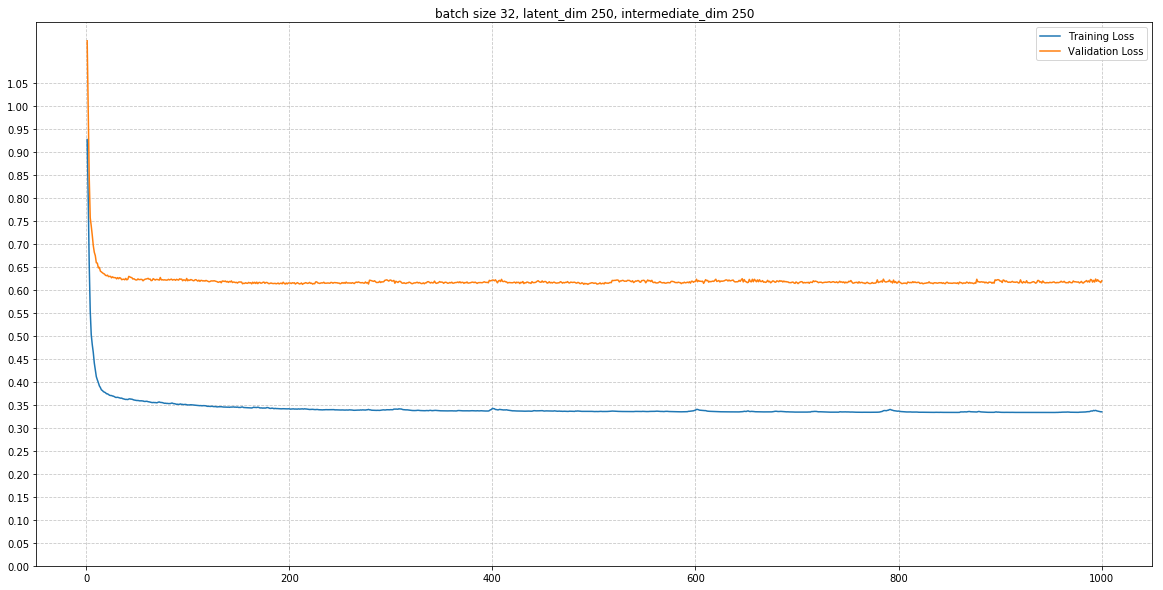

0.33352650807308226 0.6123766449450607
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.31115633407245674


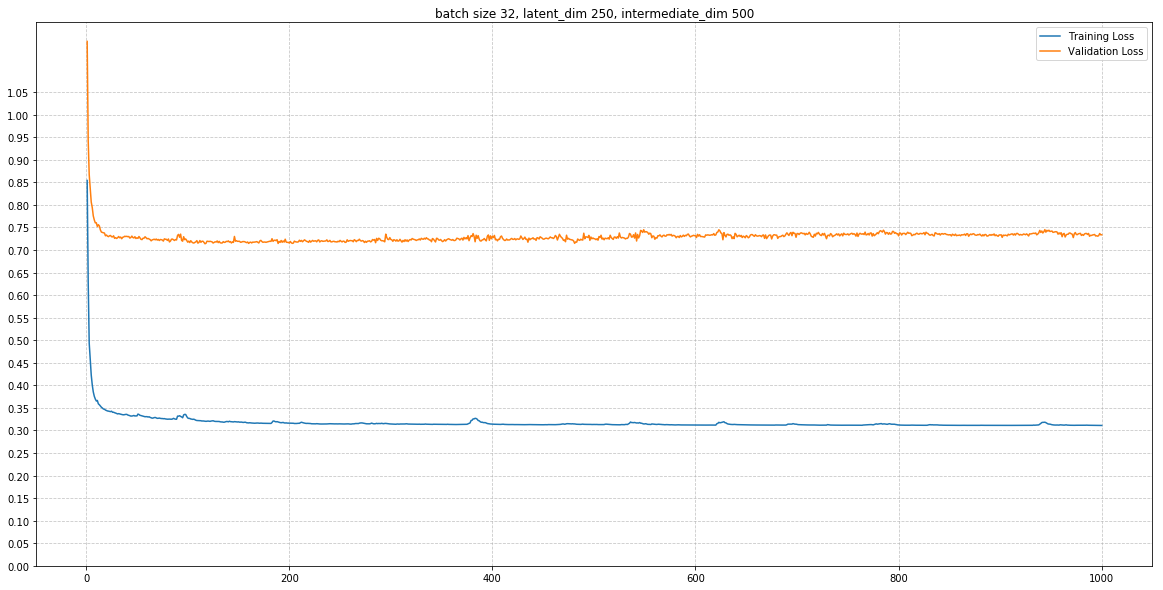

0.31115633407245674 0.7139239957634832
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.3131479931067241


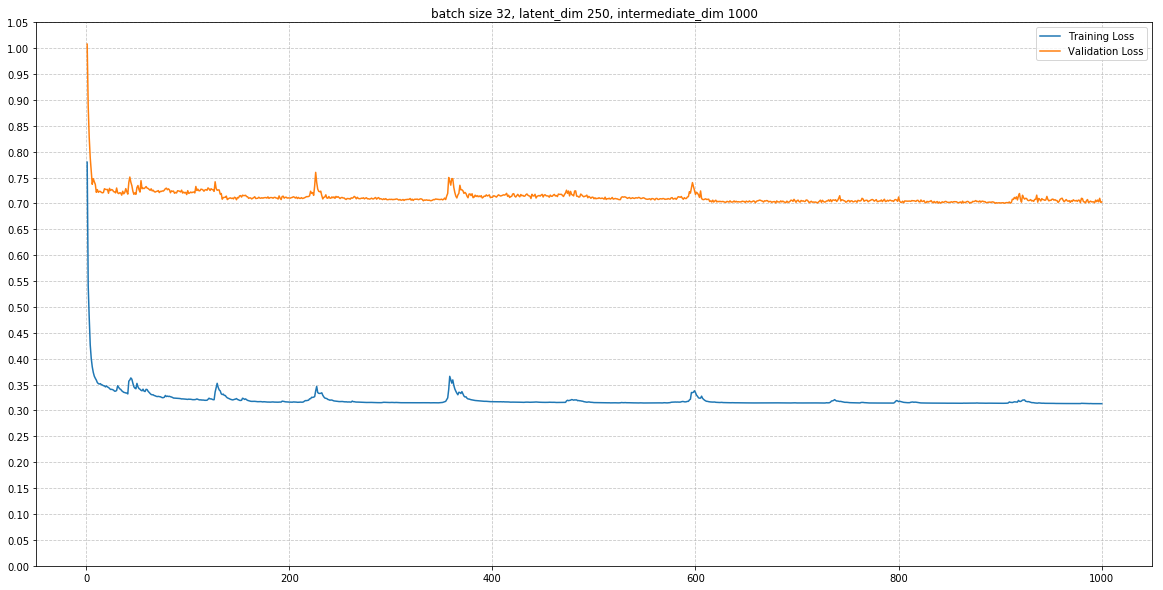

0.3131479931067241 0.7001603195365046
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.39855353692184486


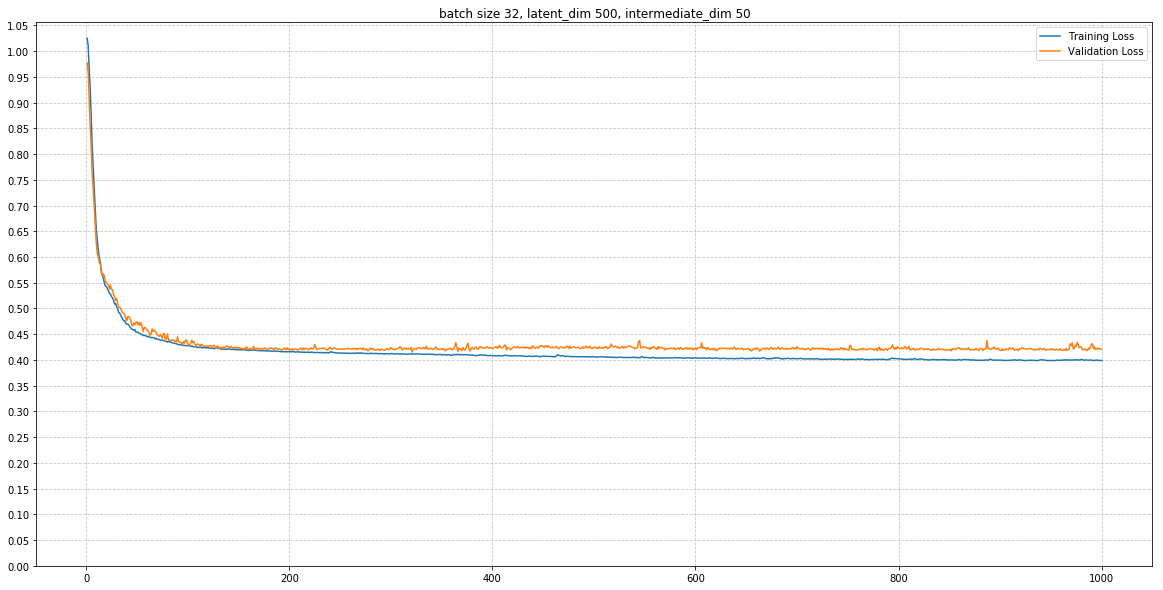

0.39855353692184486 0.41537053022586123
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.3963417125464328


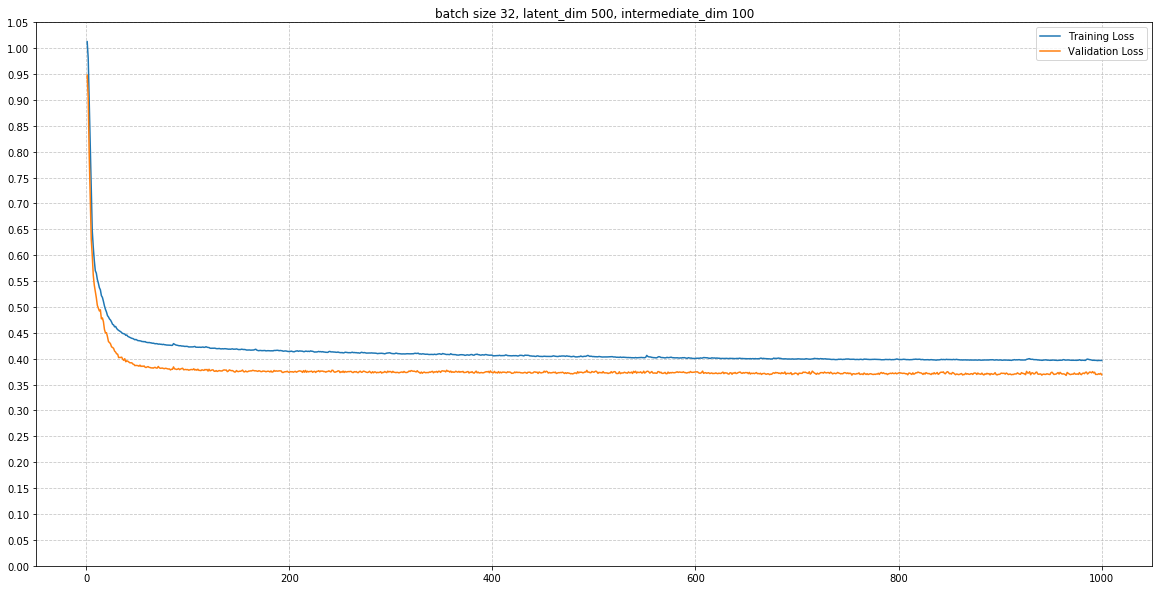

0.3963417125464328 0.3677110418047703
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.40933425950919783


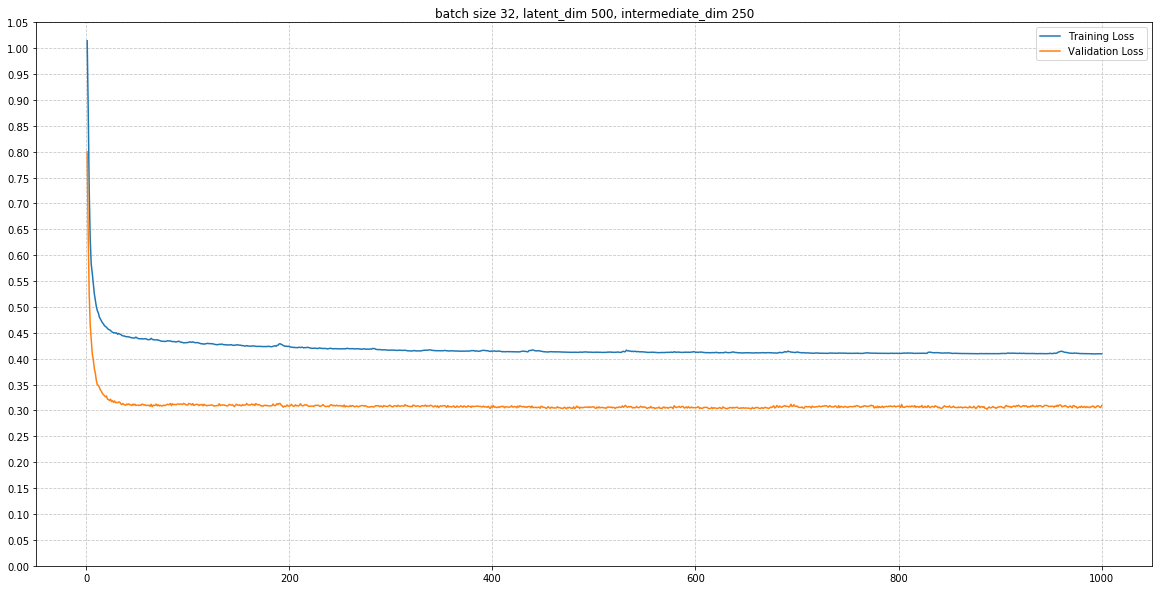

0.40933425950919783 0.3023982992474462
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.3385363958986614


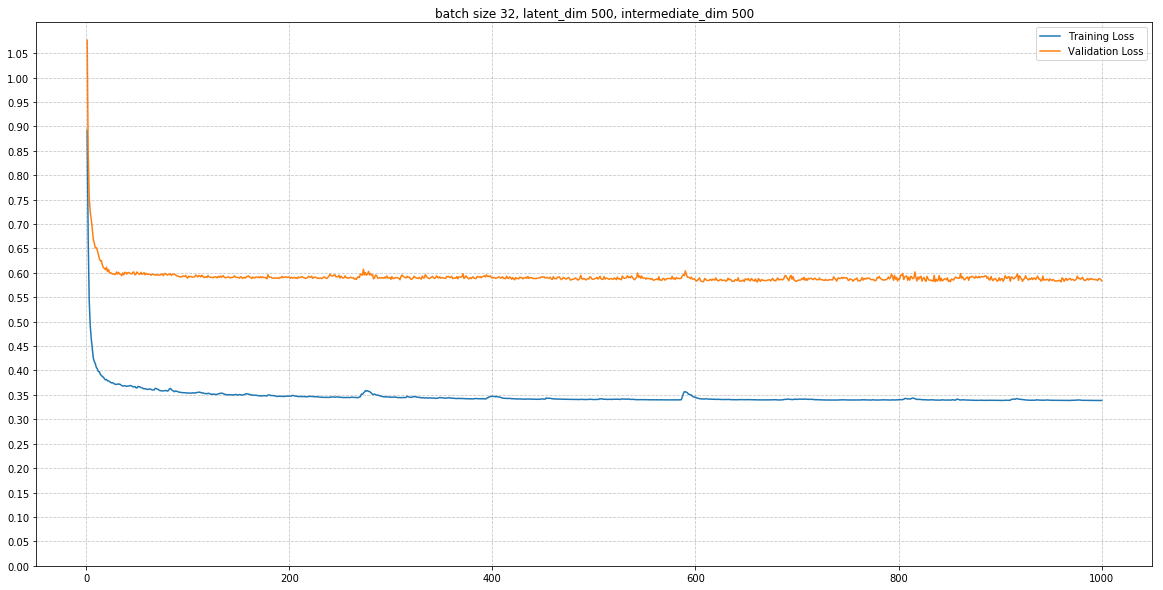

0.3385363958986614 0.5812638838526228
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.38747471865832595


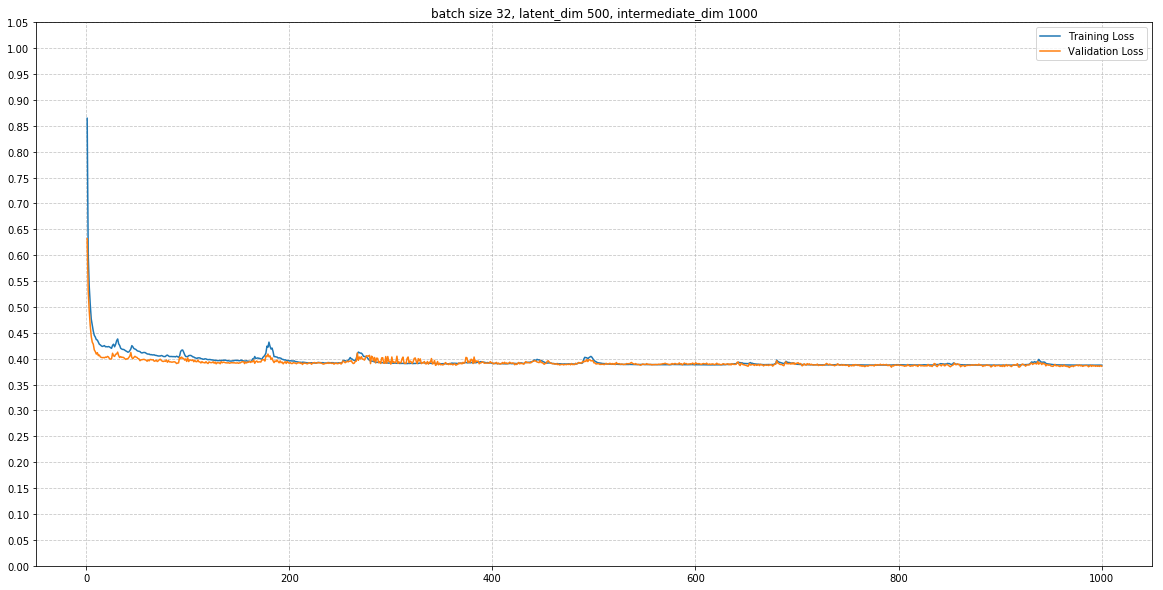

0.38747471865832595 0.3829587387367034
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.4255704214210645


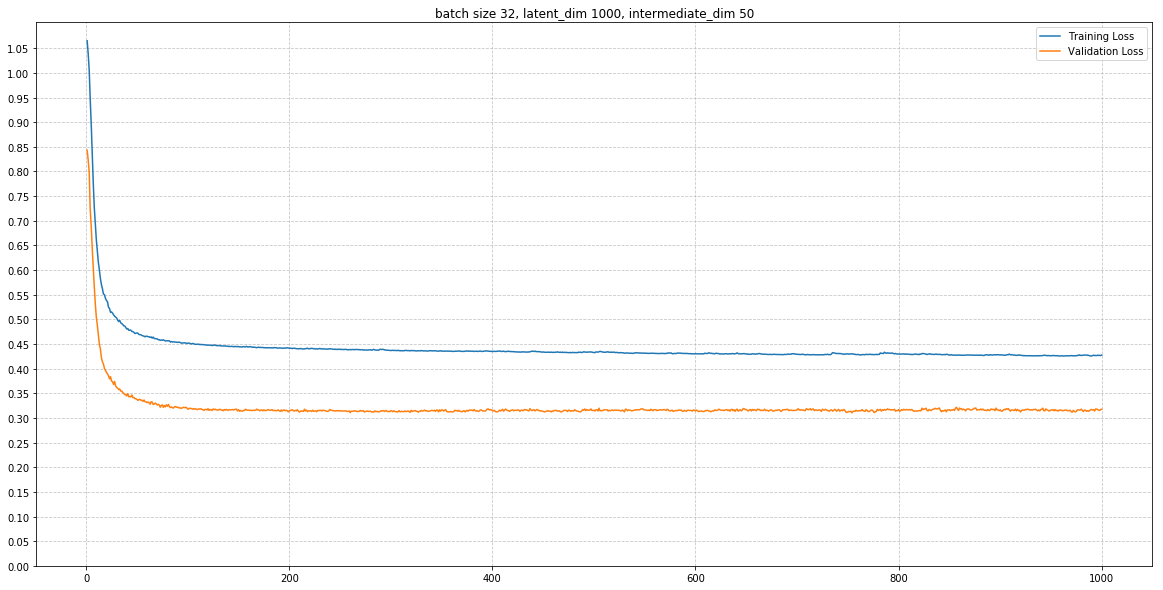

0.4255704214210645 0.31038744369862786
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.39219627363521725


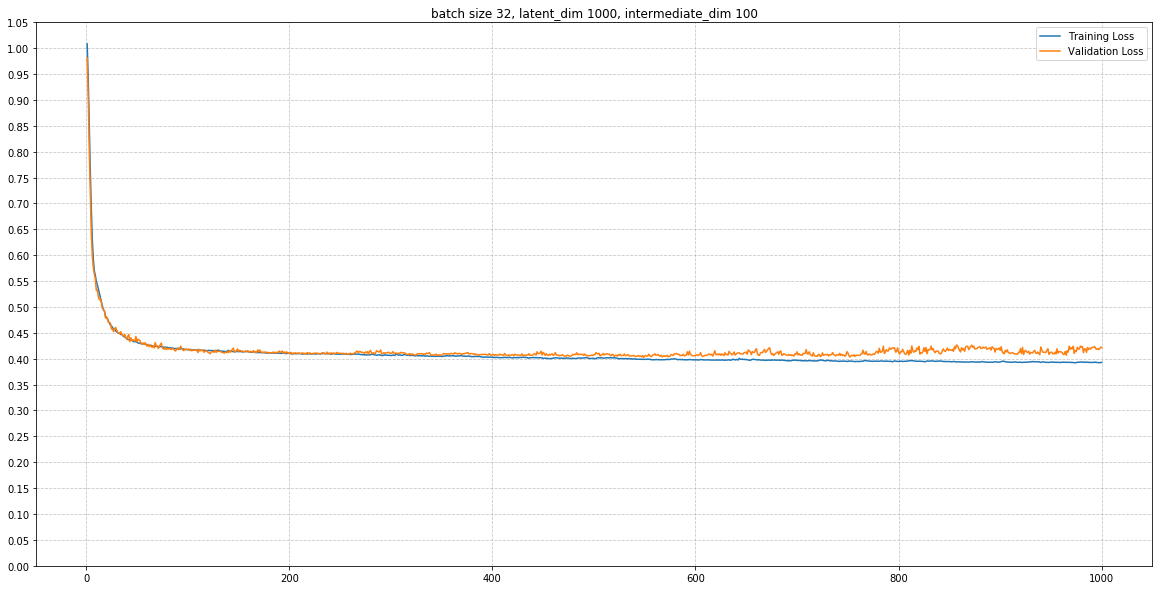

0.39219627363521725 0.40257924543300144
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.36045195030660593


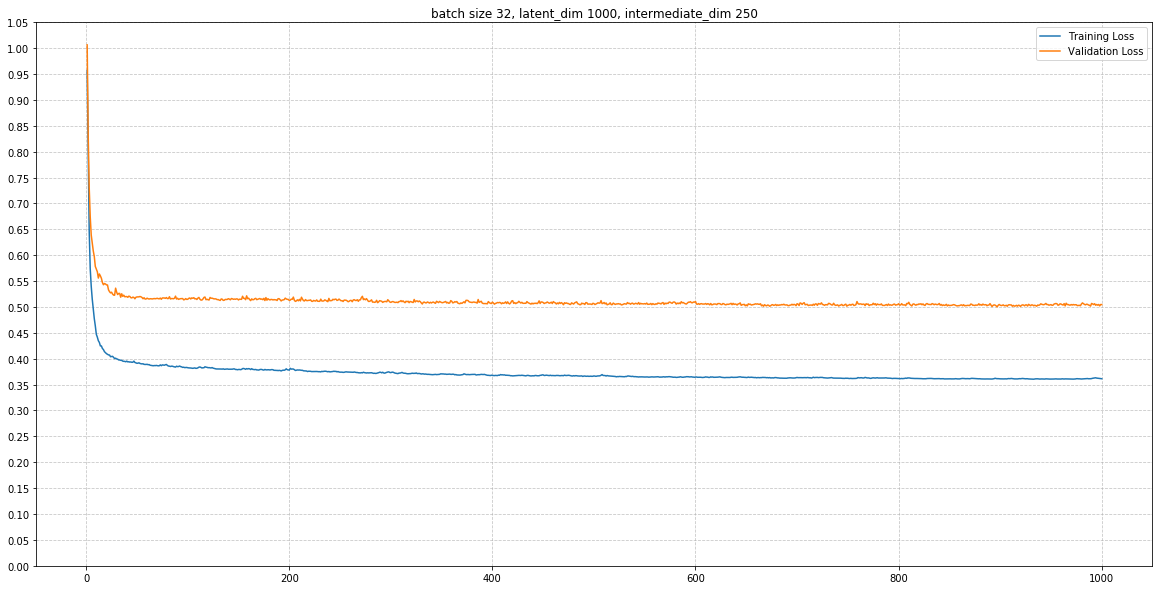

0.36045195030660593 0.5000916887337054
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.4236981266378935


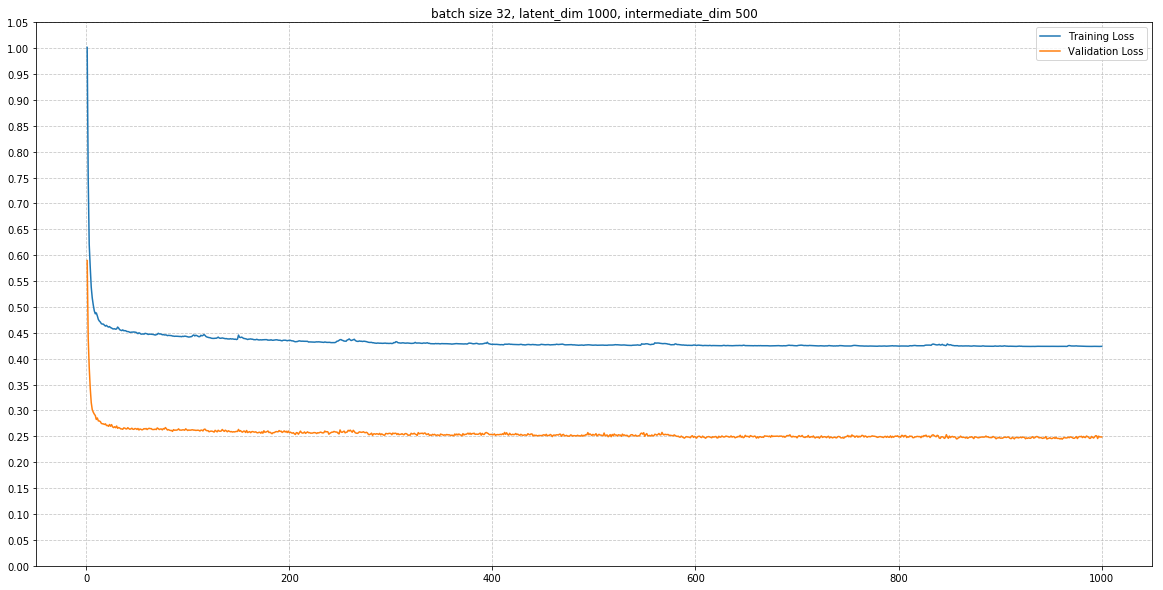

0.4236981266378935 0.24452764614367148
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.39303258766976346


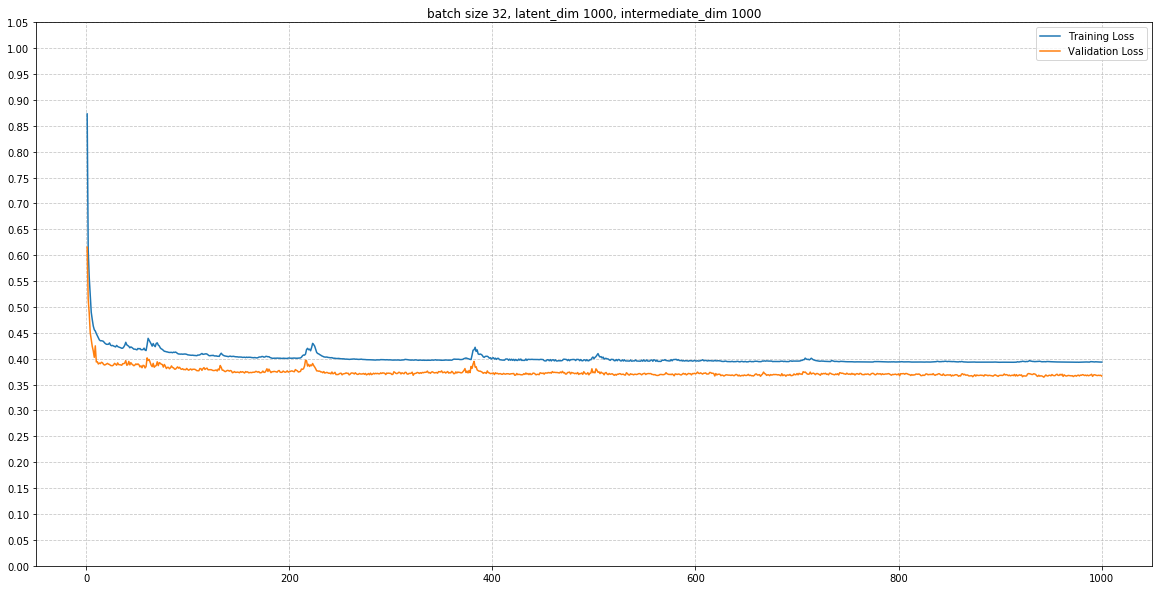

0.39303258766976346 0.3643401132922777
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.41777554859963406


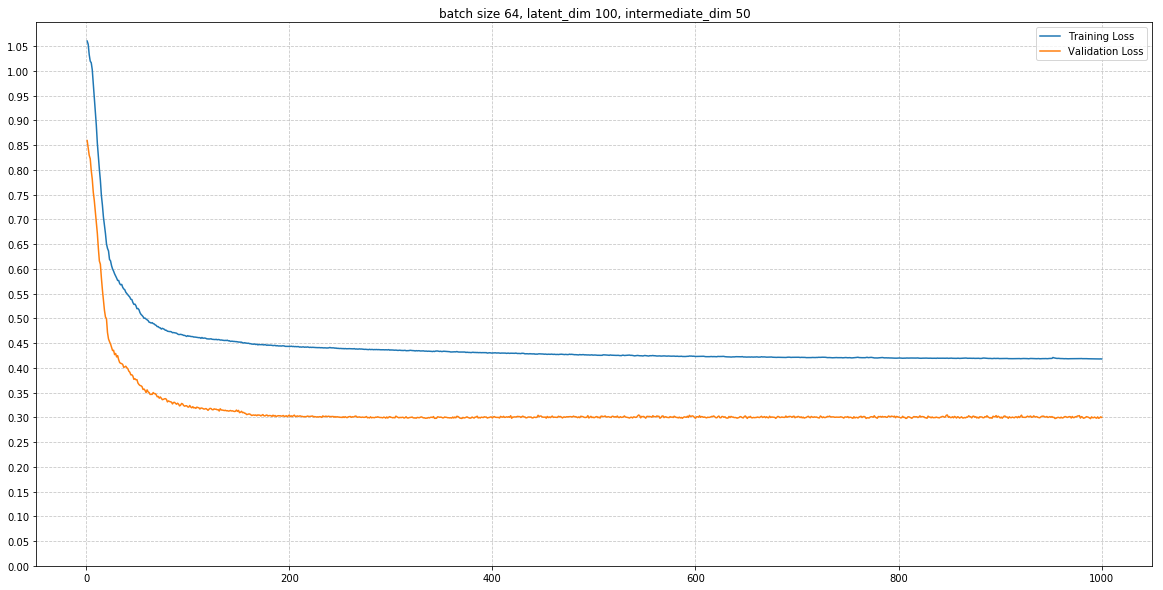

0.41777554859963406 0.29728441695931934
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.38385534855165243


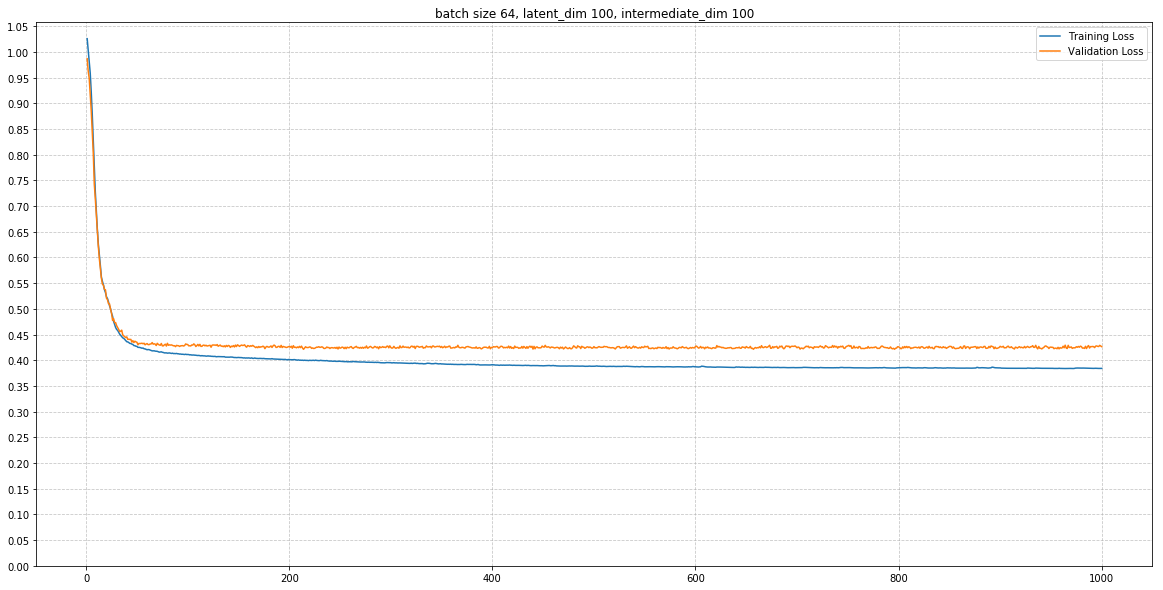

0.38385534855165243 0.42124756331175145
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.4051730634888154


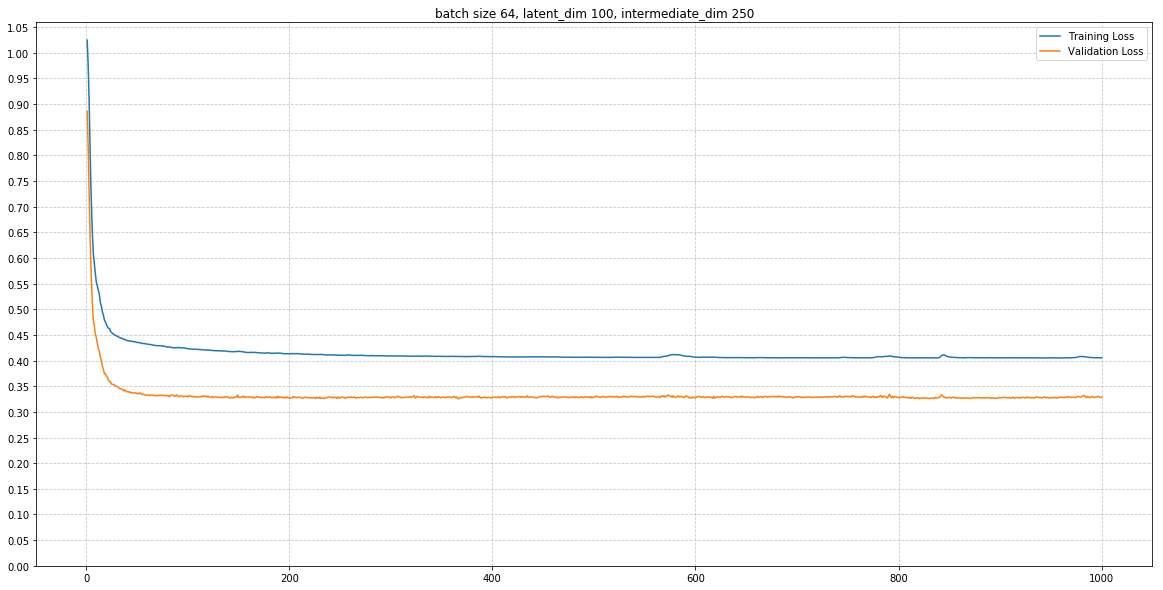

0.4051730634888154 0.3253717663842188
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.35619563517216657


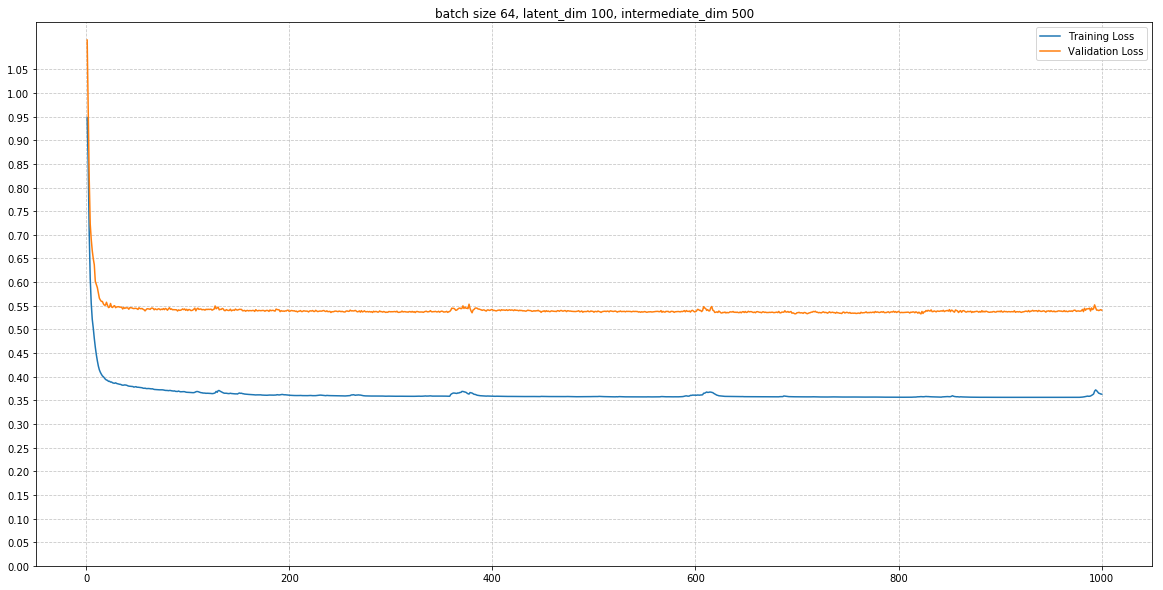

0.35619563517216657 0.5326658982626149
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.3982745003573886


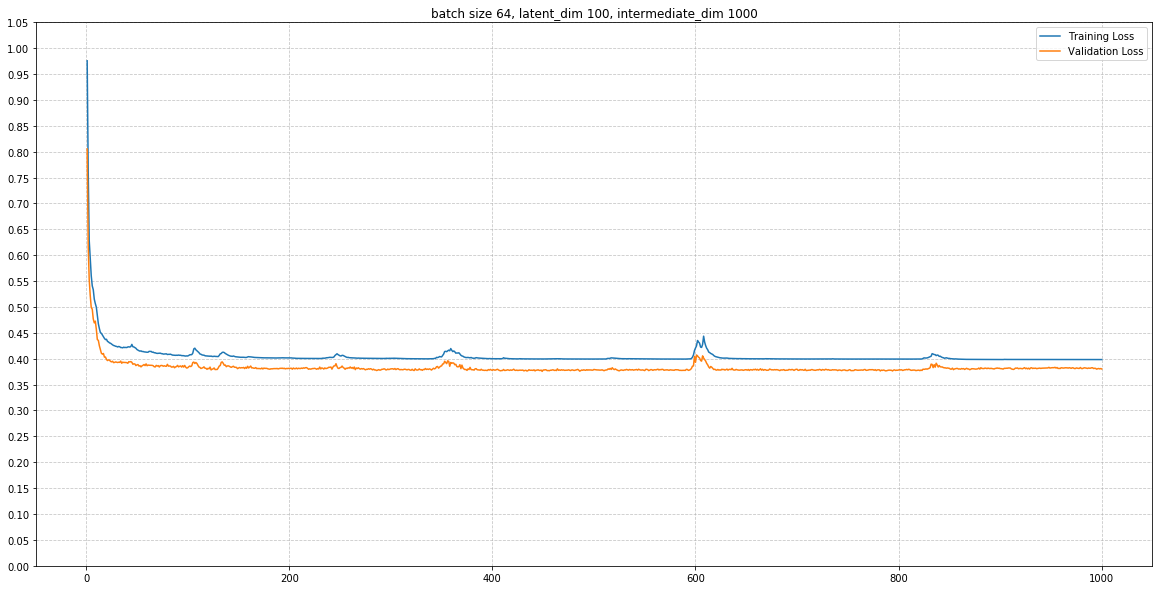

0.3982745003573886 0.37554405262352714
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.40595167243438557


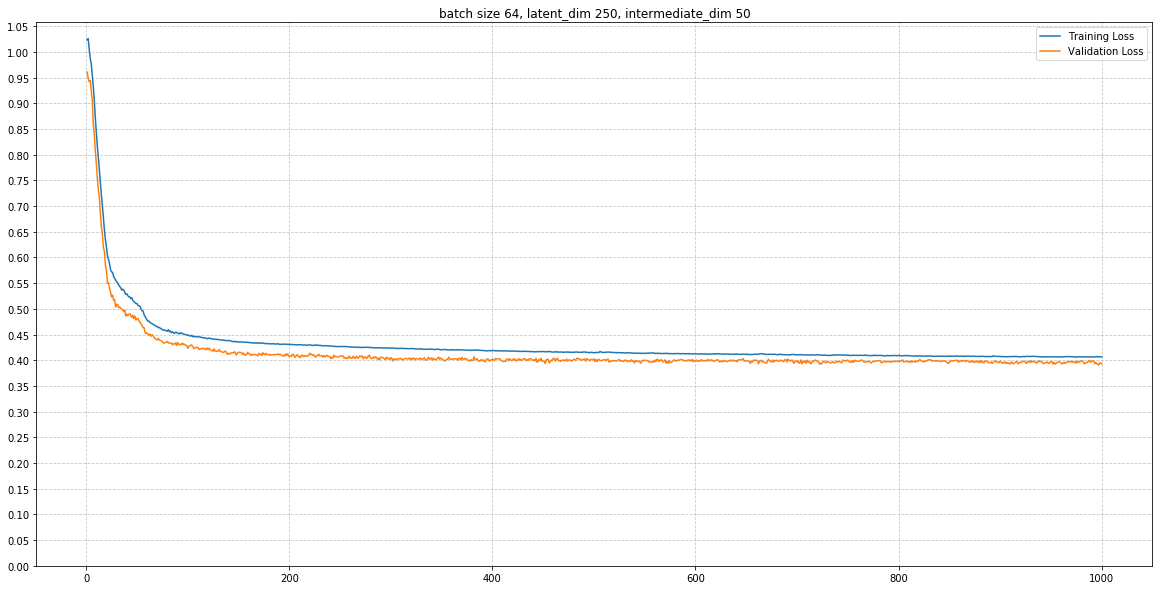

0.40595167243438557 0.39049020199708534
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.37030745890031014


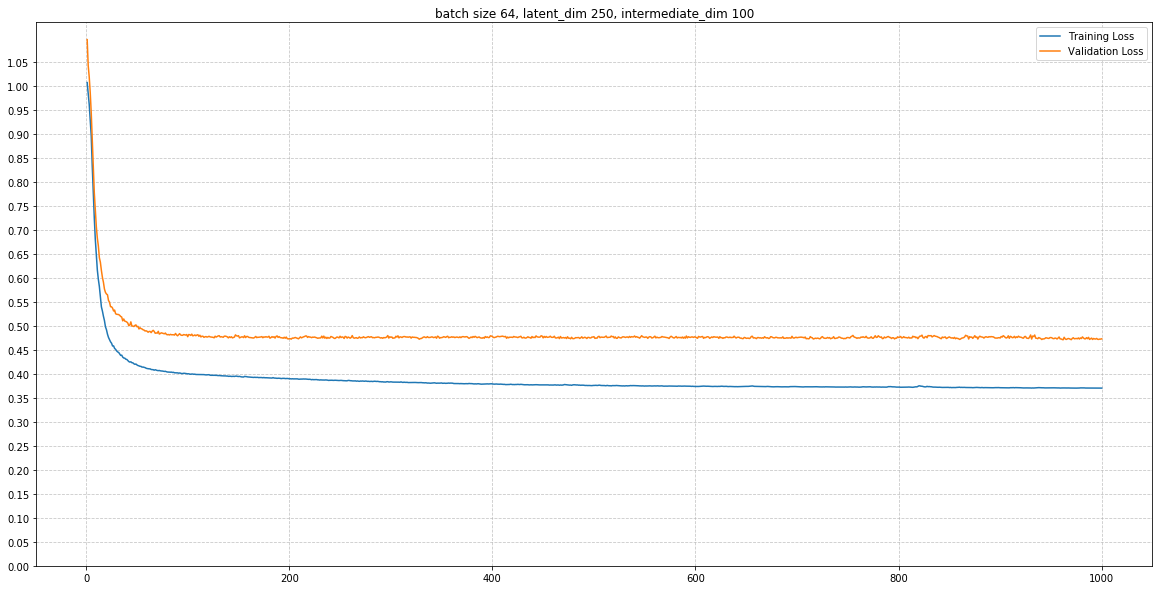

0.37030745890031014 0.4711748783437299
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.4095977471068554


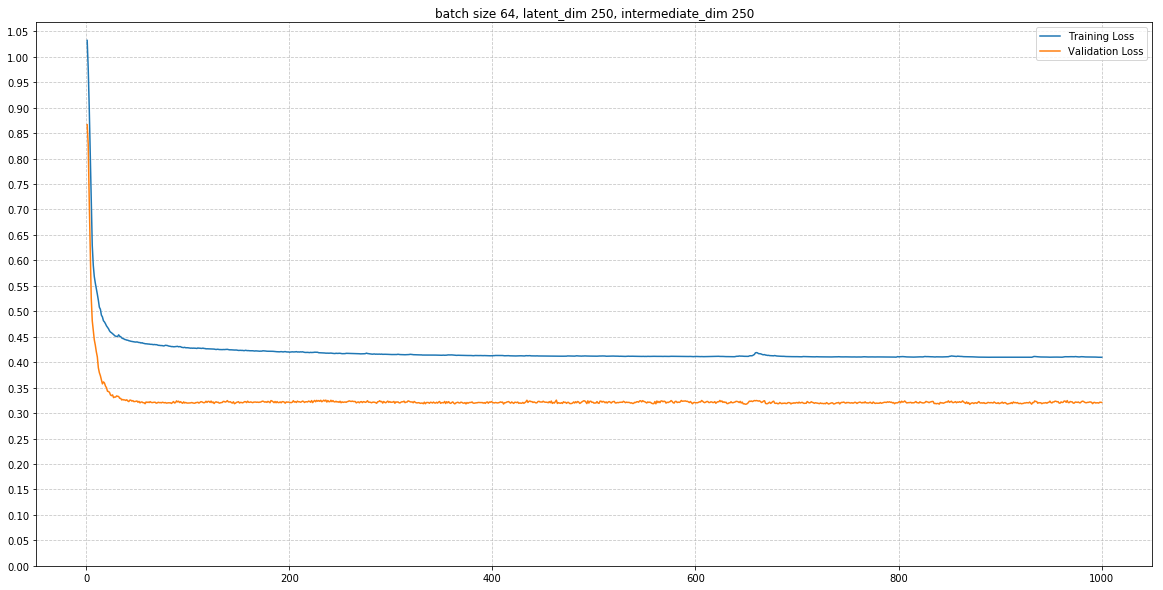

0.4095977471068554 0.3170778593966659
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.3965767569339739


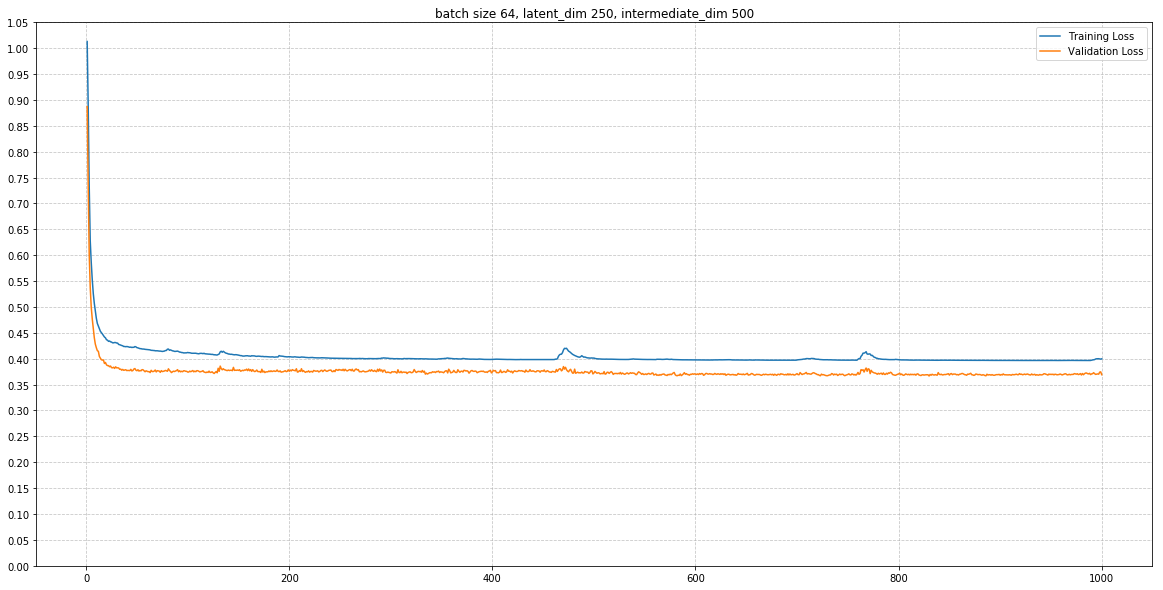

0.3965767569339739 0.36661776102764504
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.41097841109066885


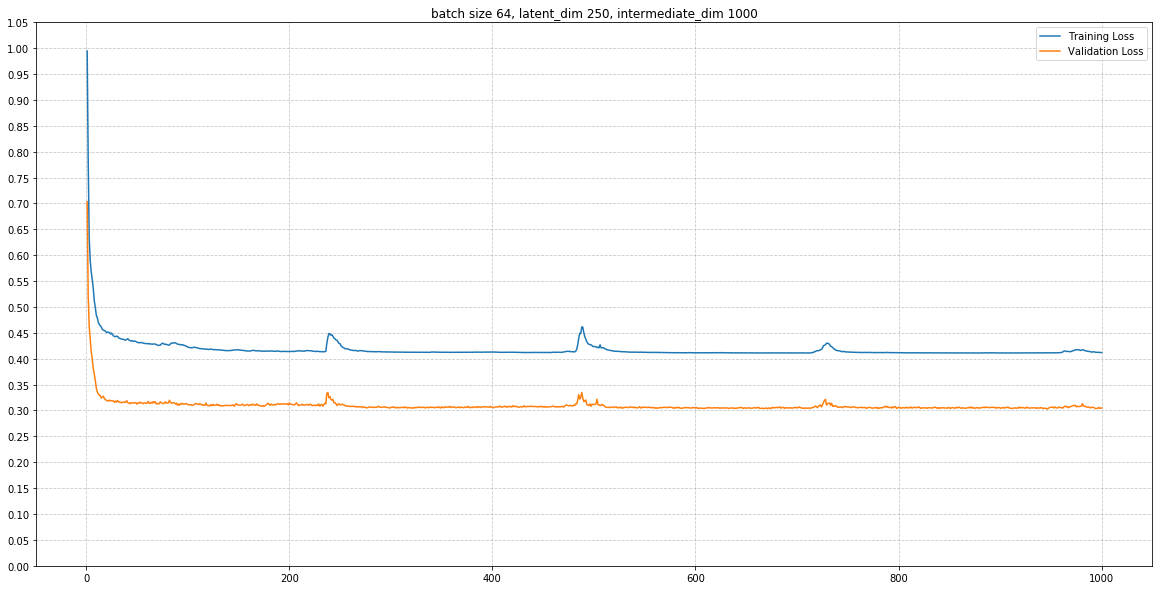

0.41097841109066885 0.30275292799506387
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.39247843939086996


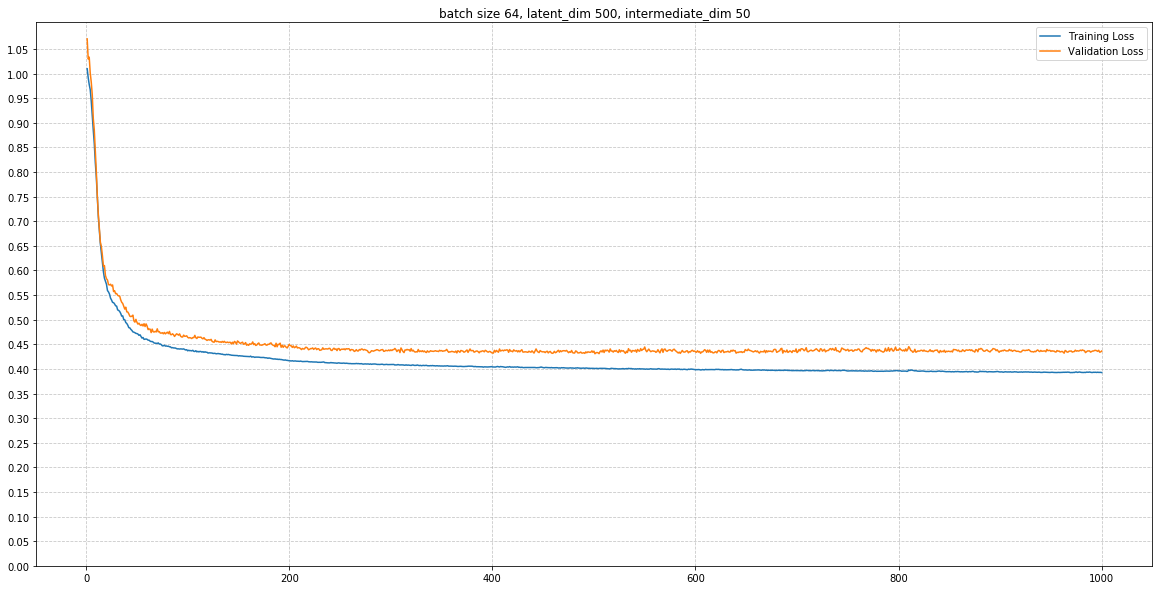

0.39247843939086996 0.43079998228751437
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.3608817837263586


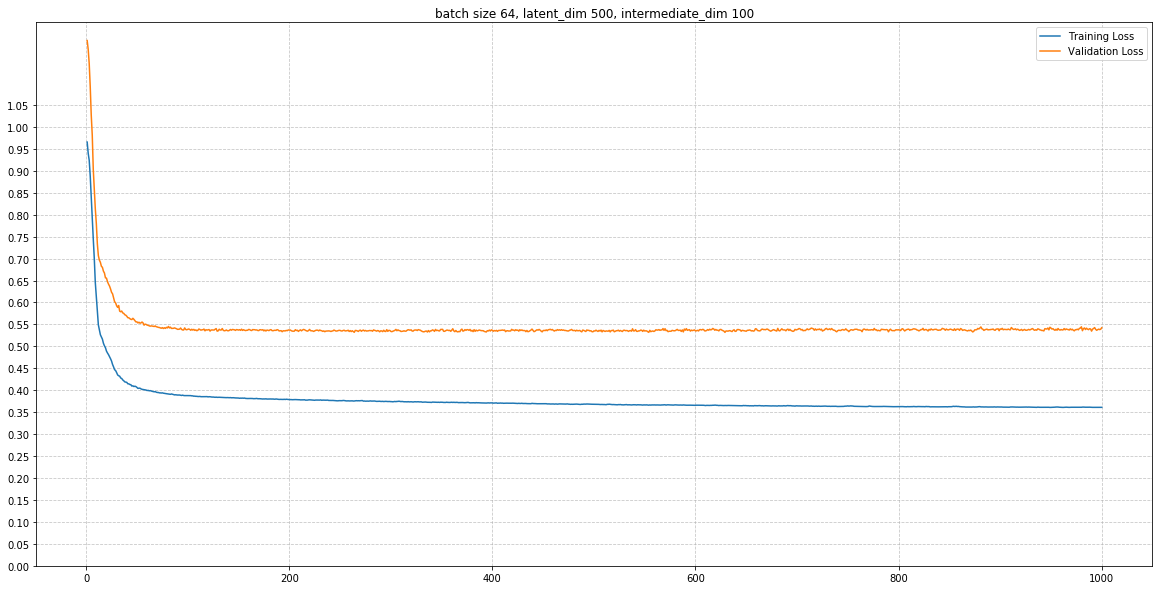

0.3608817837263586 0.5319143953457685
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.42140647063406955


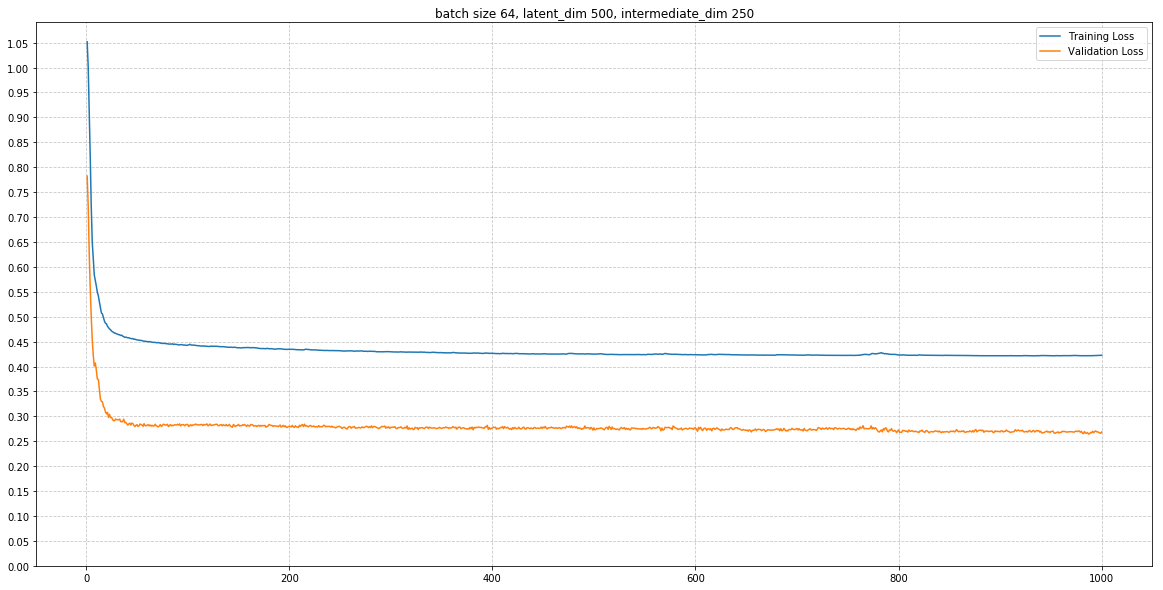

0.42140647063406955 0.2643649232849269
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.3167273991415442


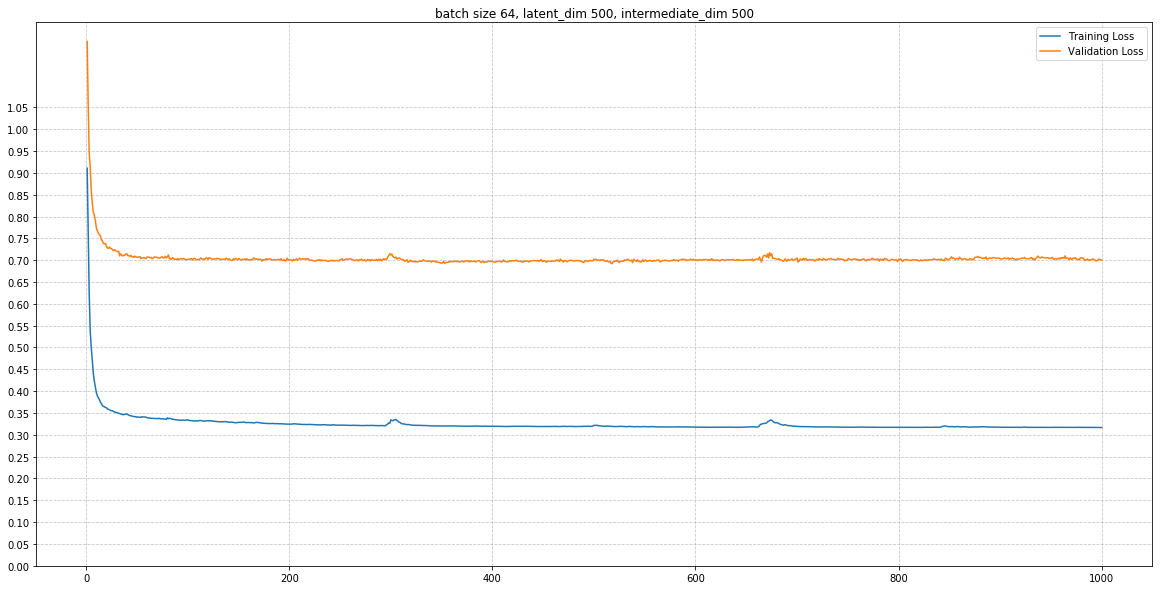

0.3167273991415442 0.6922363525545093
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.38205876872733285


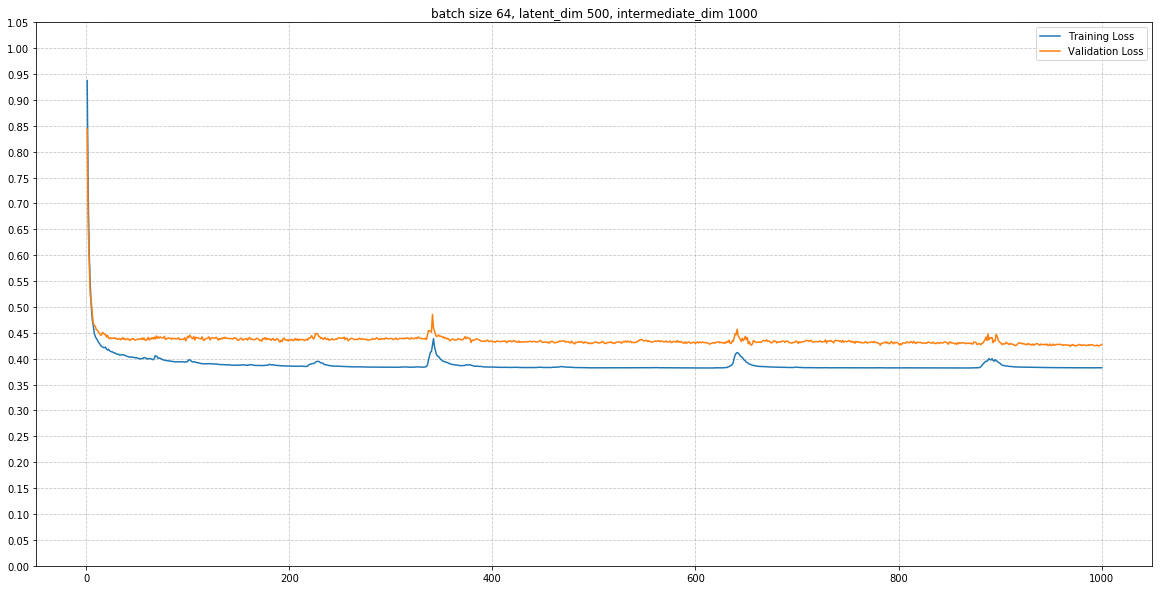

0.38205876872733285 0.42378848119520807
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.4500313782965758


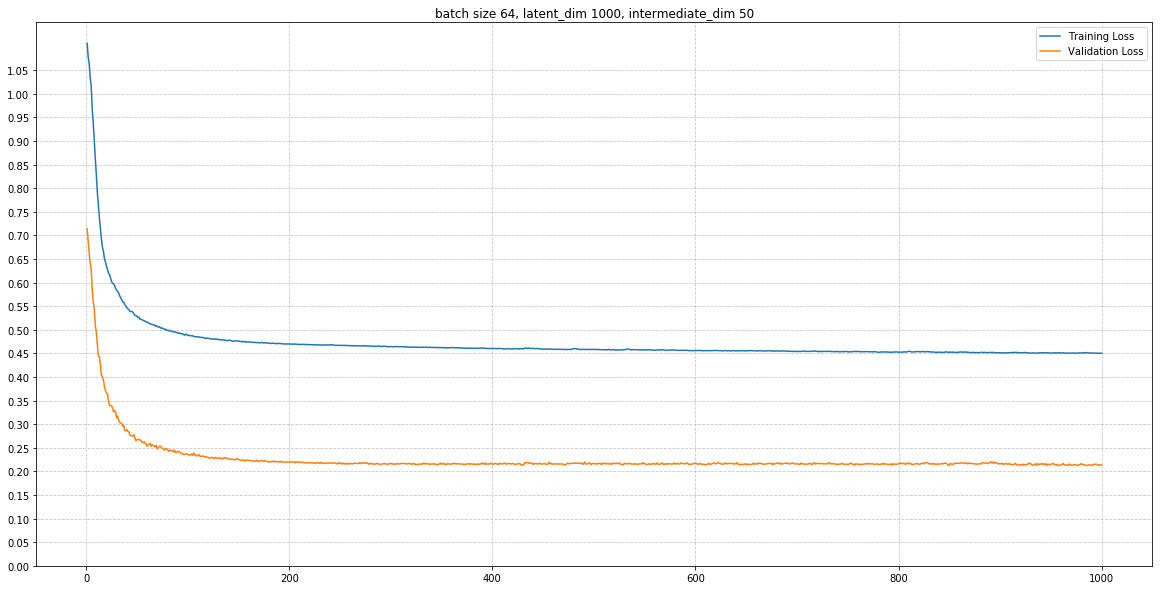

0.4500313782965758 0.21194846886144558
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.39238948009039404


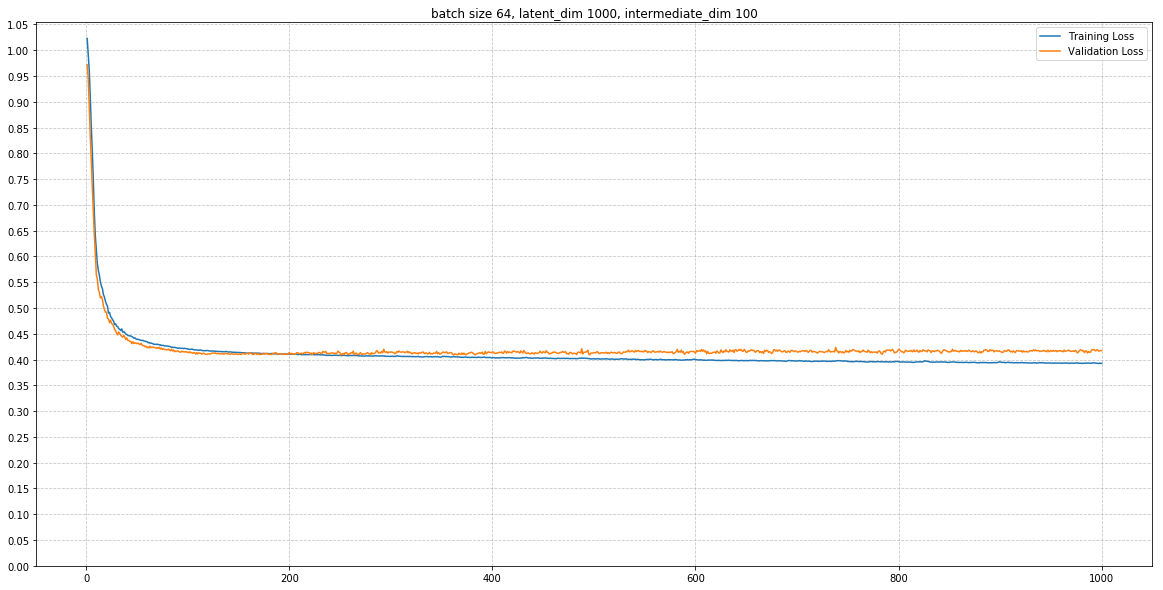

0.39238948009039404 0.40872877164625787
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.4122234275400007


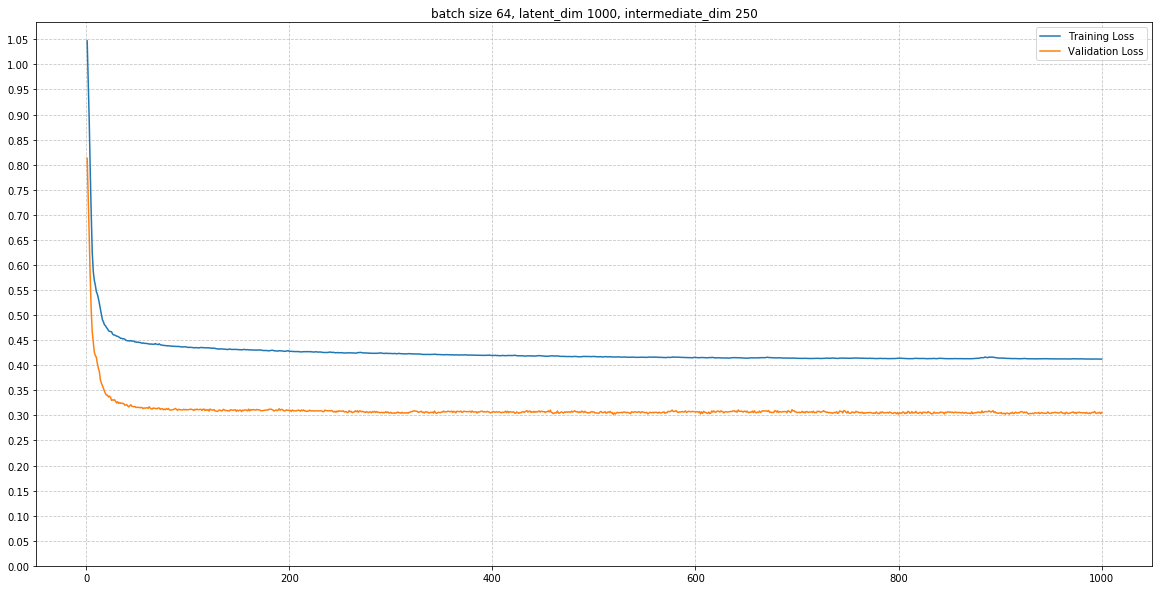

0.4122234275400007 0.3020266277689329
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.39160577347337566


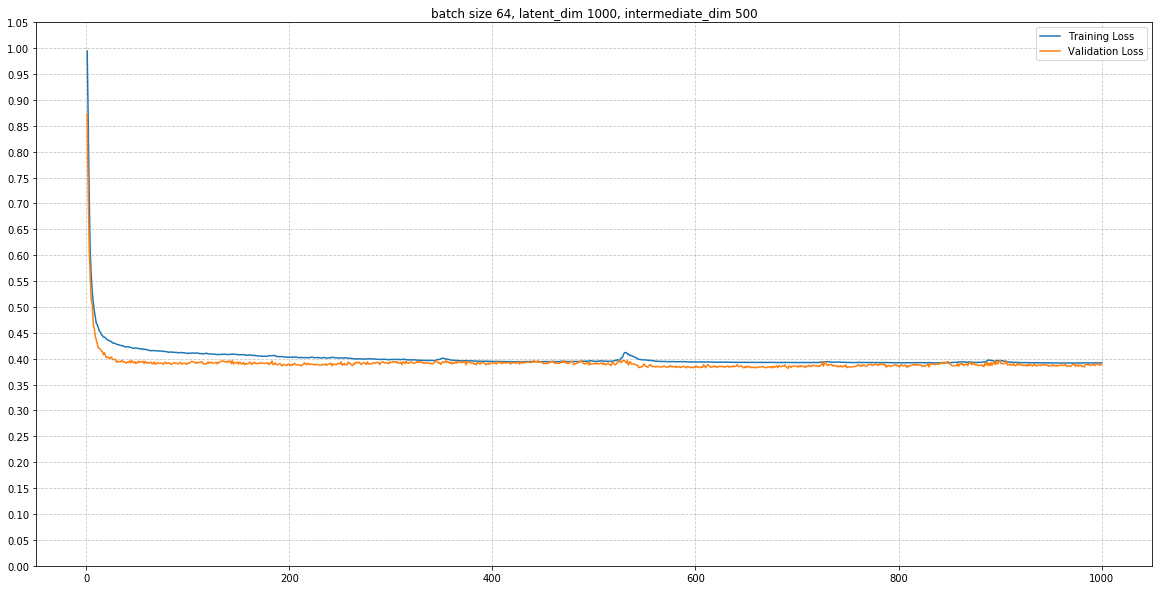

0.39160577347337566 0.38117034376507075
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.35398708668277457


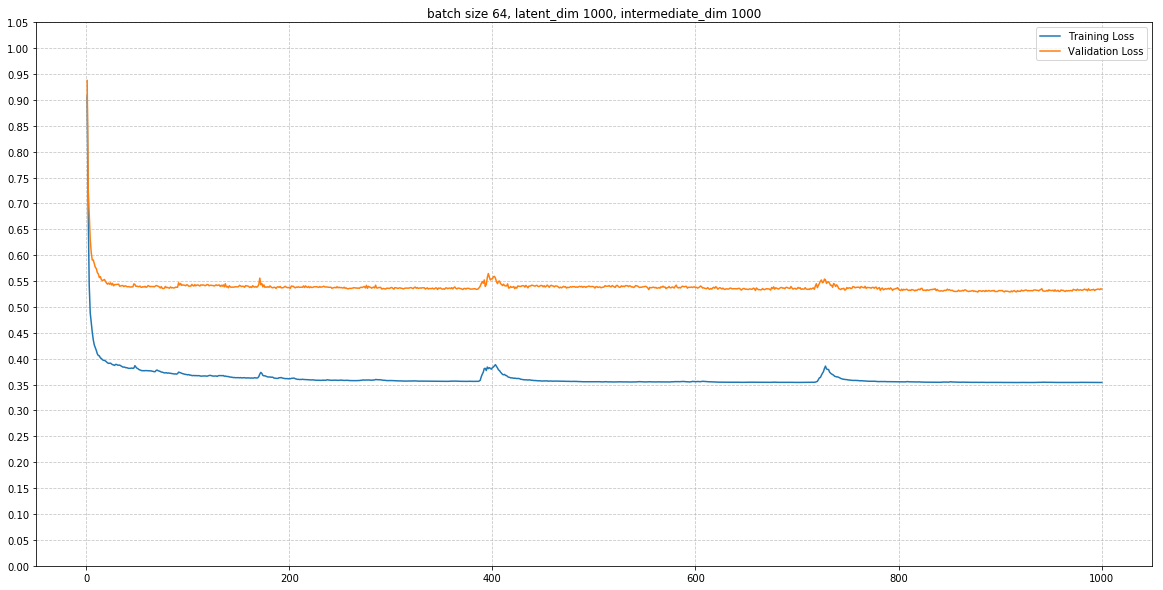

0.35398708668277457 0.5287579171831759
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.42534088267033177


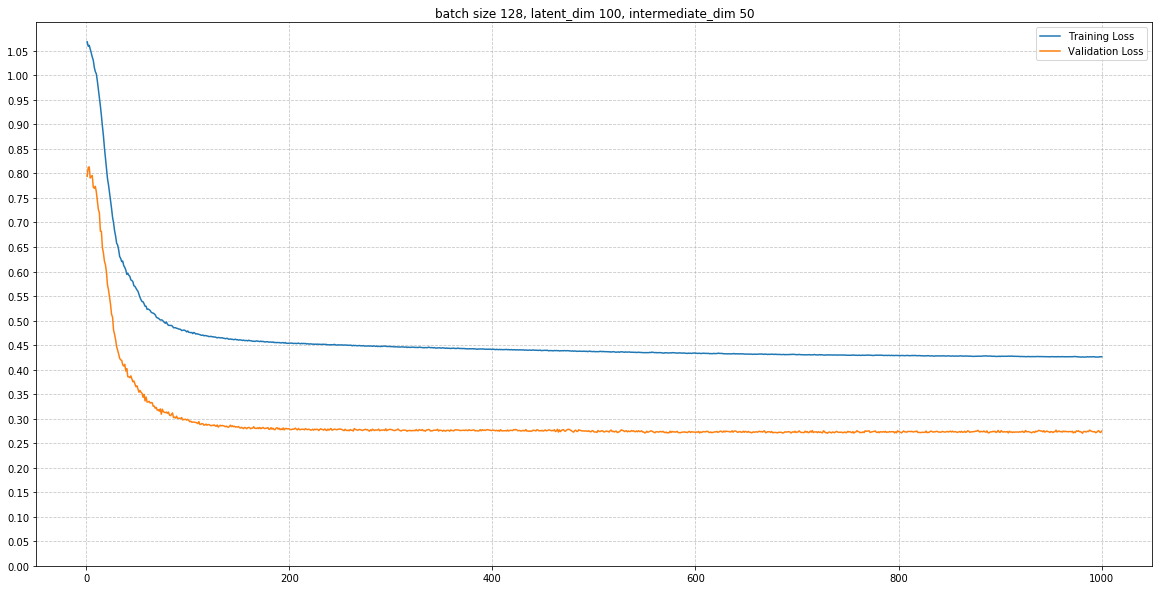

0.42534088267033177 0.2701767766979379
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.39878289754314894


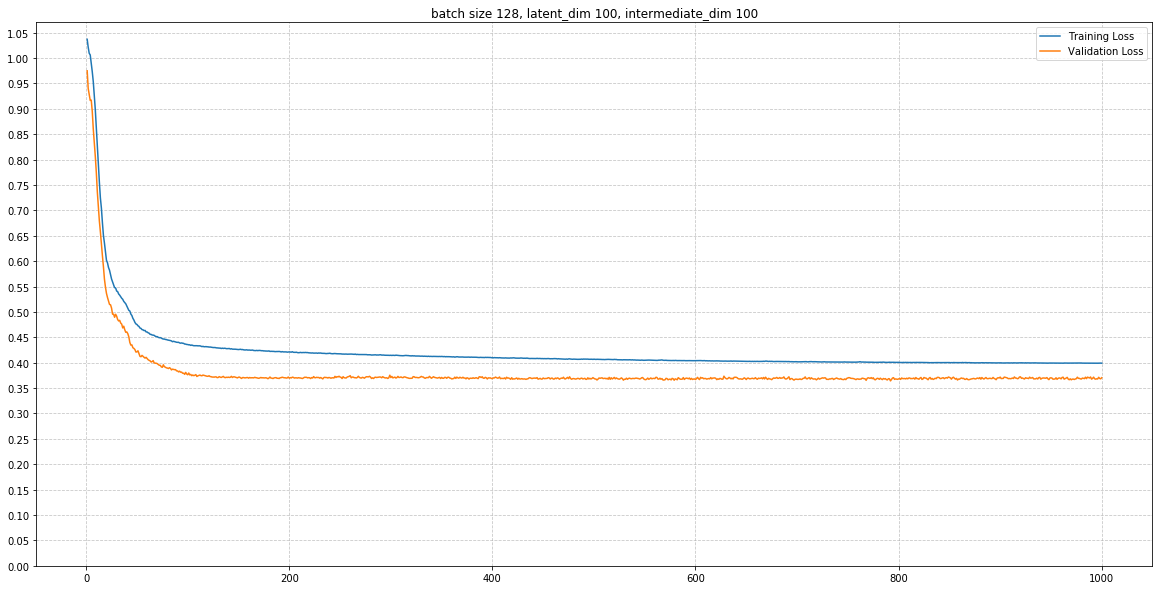

0.39878289754314894 0.36416703882351725
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.3899791080623128


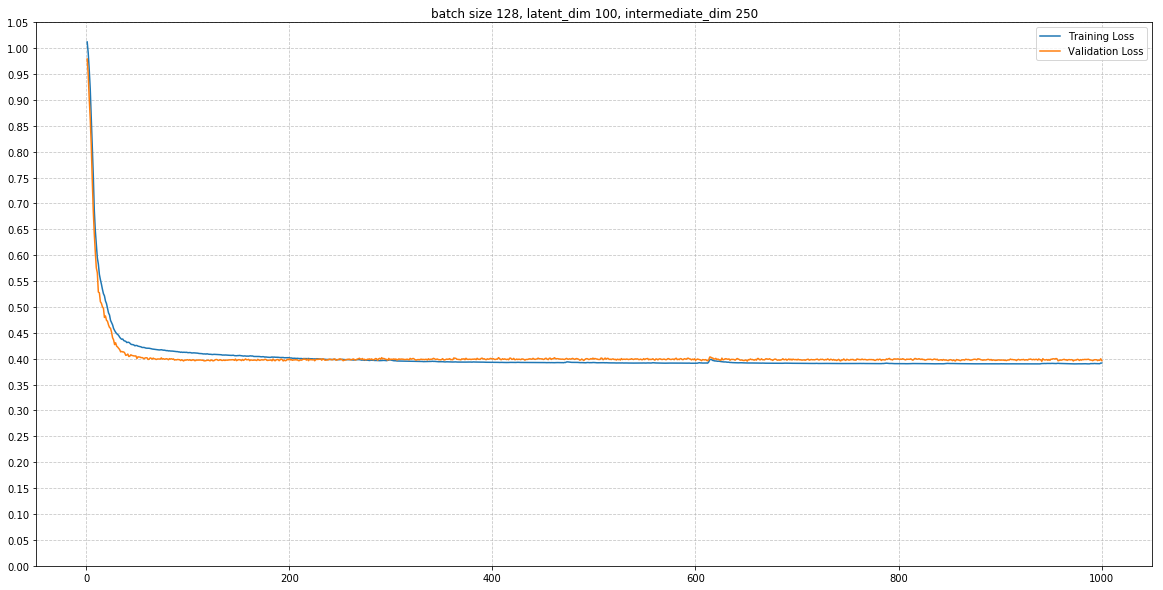

0.3899791080623128 0.39506661178360525
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.3941078084938939


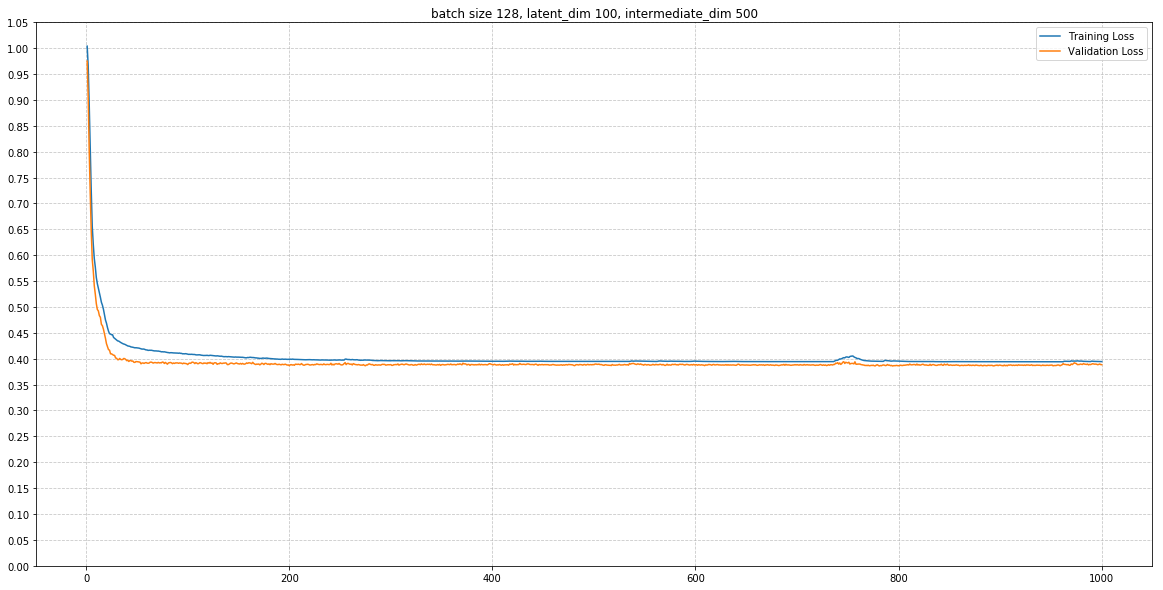

0.3941078084938939 0.3859004742977485
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.3961391482673349


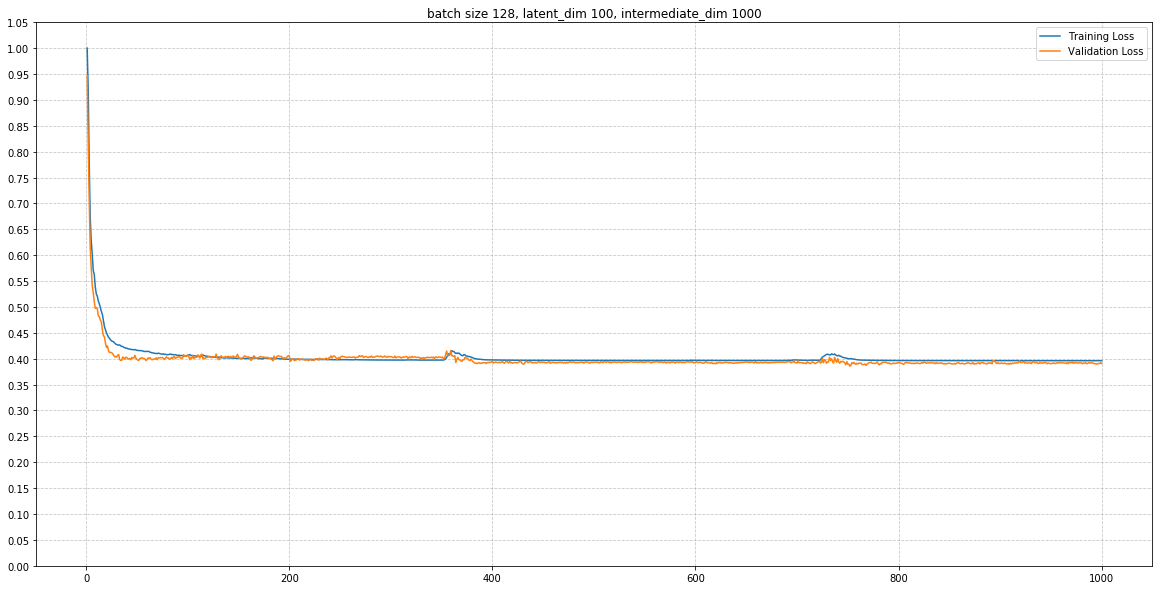

0.3961391482673349 0.38546532896203056
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.38936692623704566


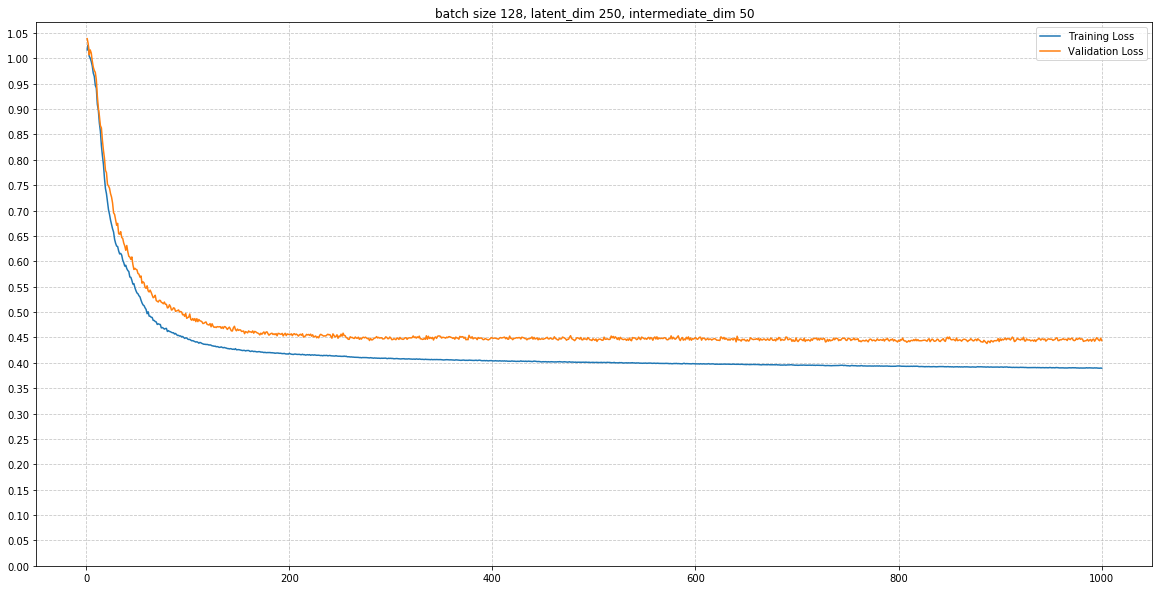

0.38936692623704566 0.43798243663680386
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.3084696913565848


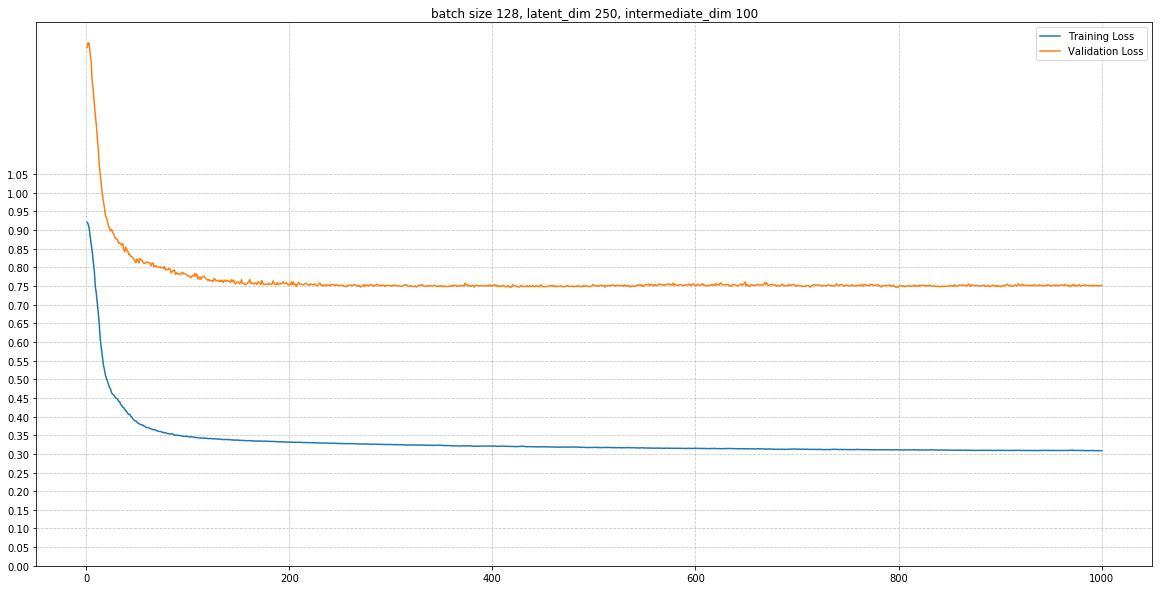

0.3084696913565848 0.7459758310250832
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.3887648350779665


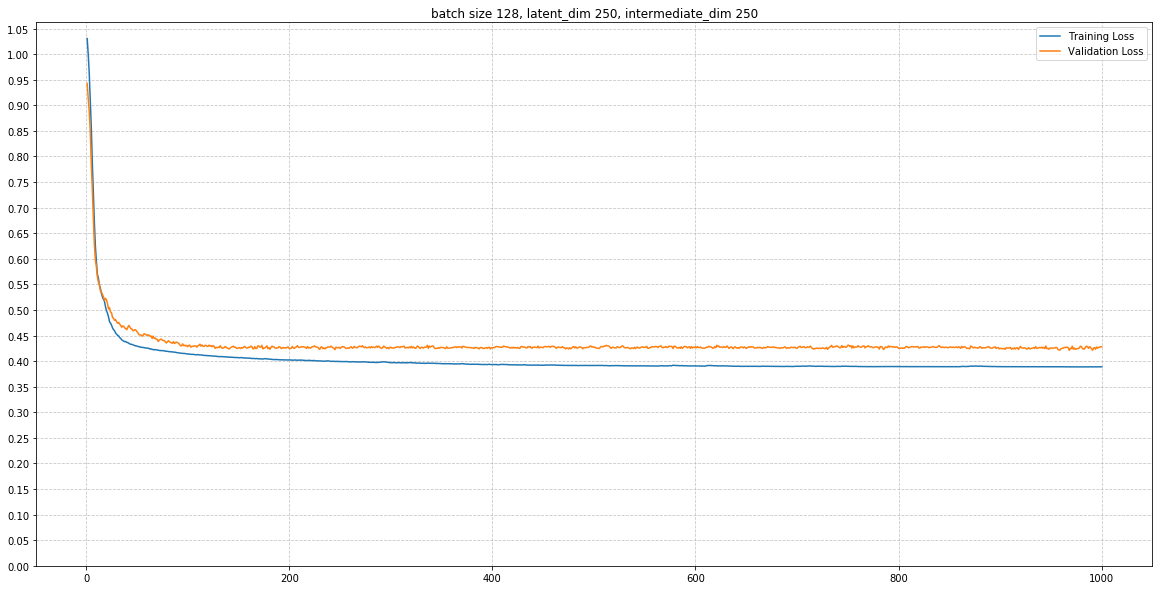

0.3887648350779665 0.4211583281276931
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.3825685679912567


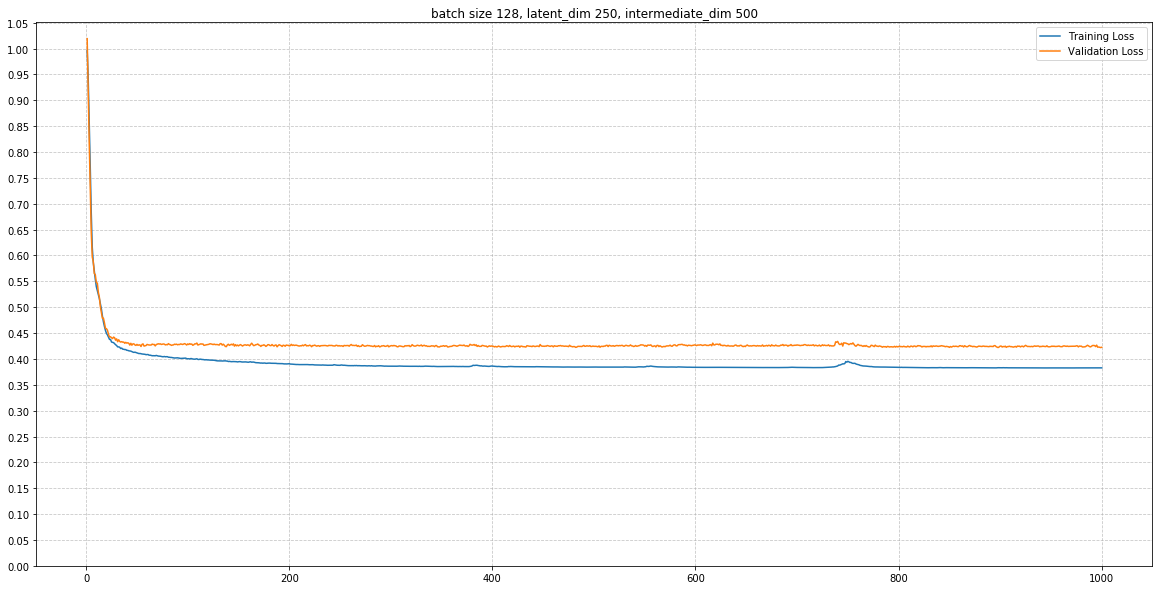

0.3825685679912567 0.42195641532750194
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.4096347412667089


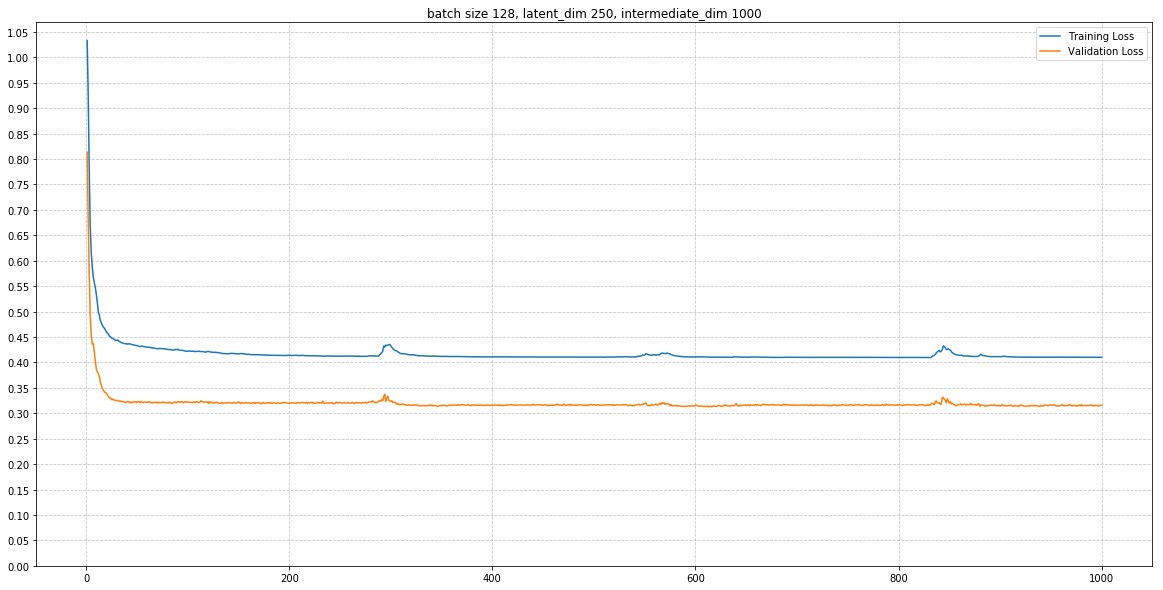

0.4096347412667089 0.3123567284832538
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.4238899556571098


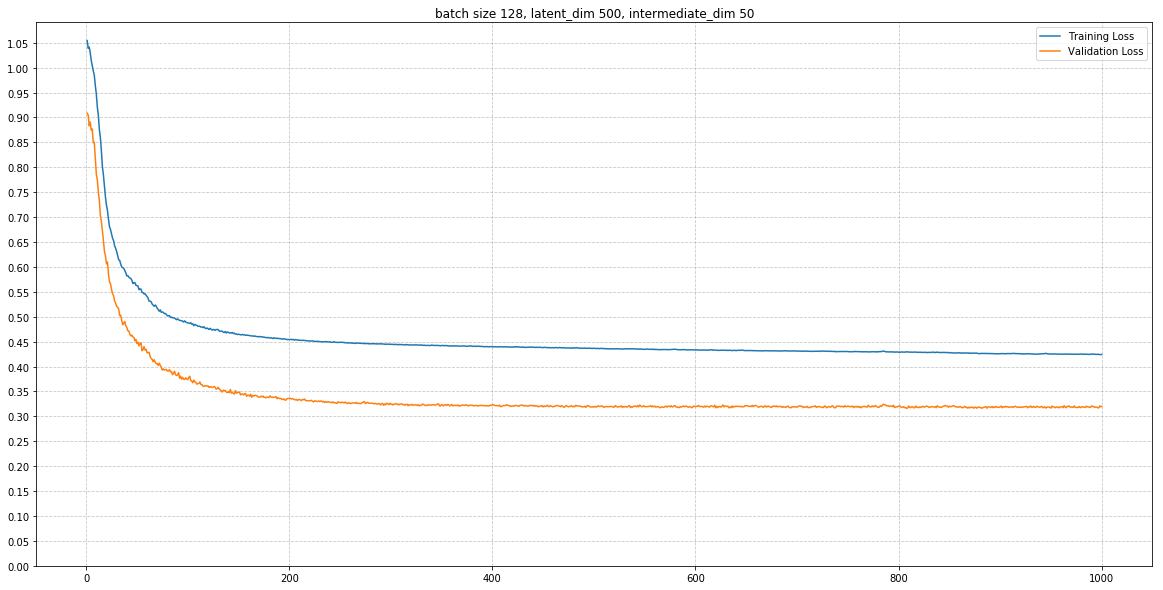

0.4238899556571098 0.3159769962371235
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.416036144478161


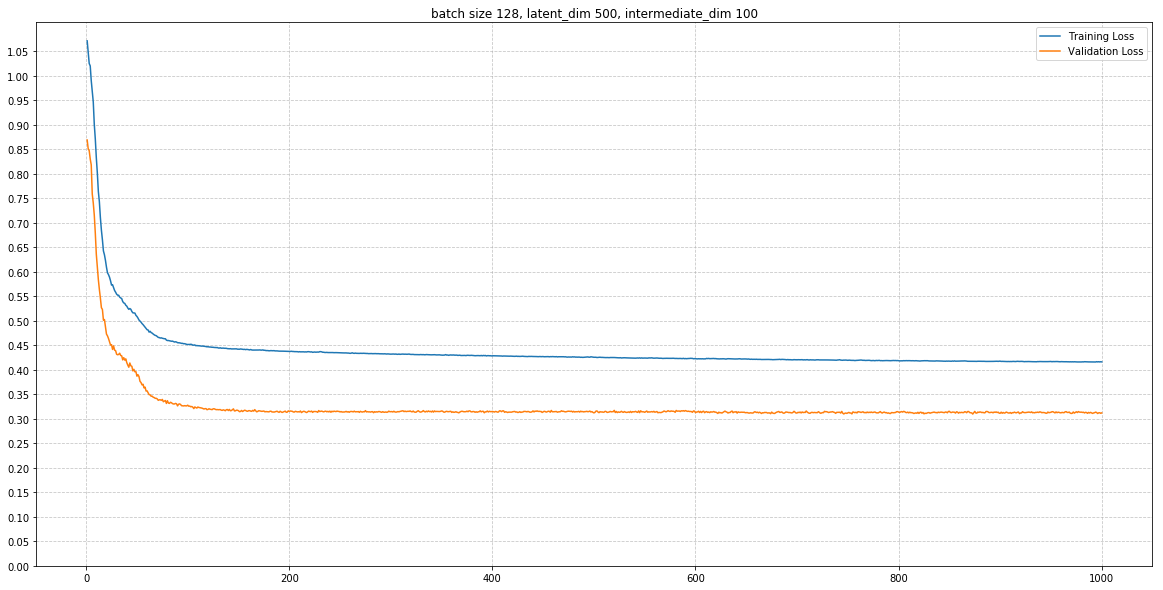

0.416036144478161 0.3097638615839918
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.37267205013824434


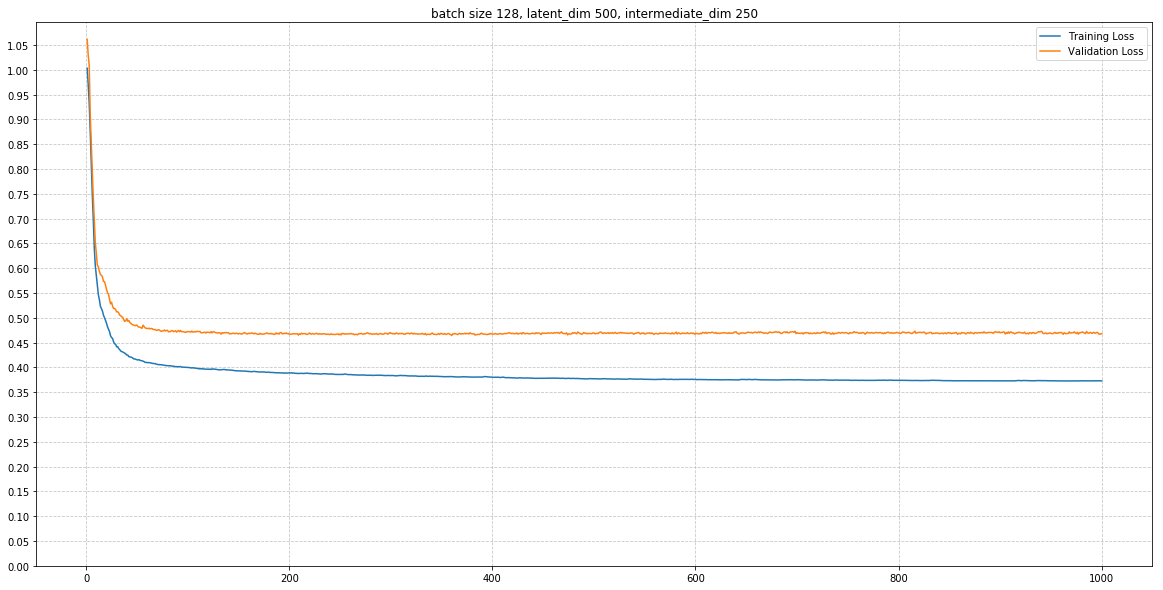

0.37267205013824434 0.46440351764920734
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.3255315873732415


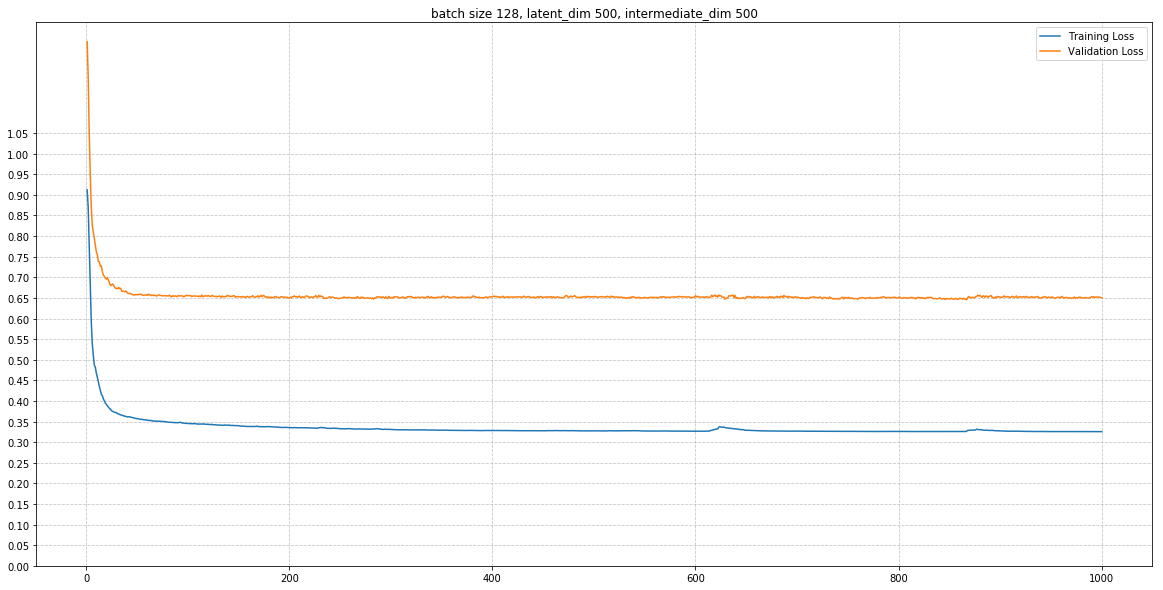

0.3255315873732415 0.6455373176386658
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.37830385218239504


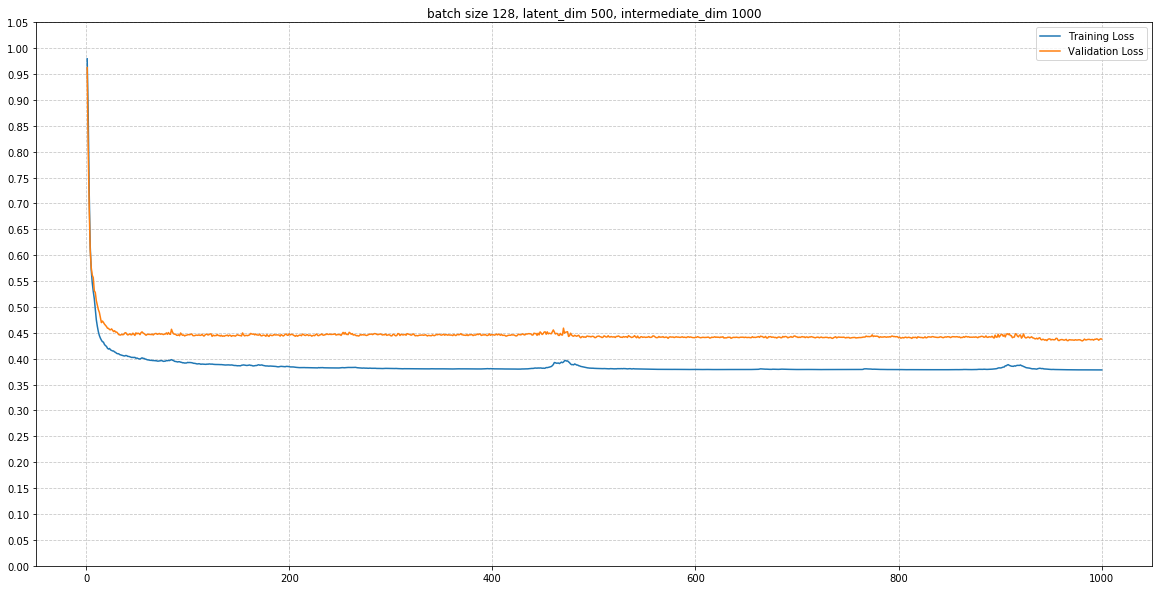

0.37830385218239504 0.4344220430078641
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.40587312825577


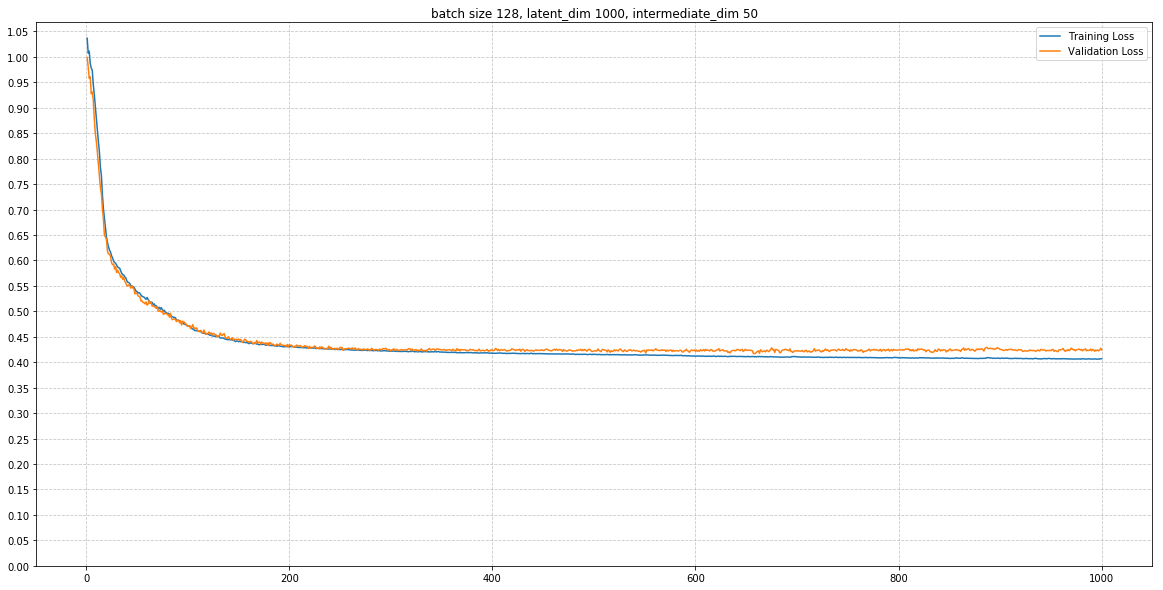

0.40587312825577 0.41673425301699574
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.33422346292030686


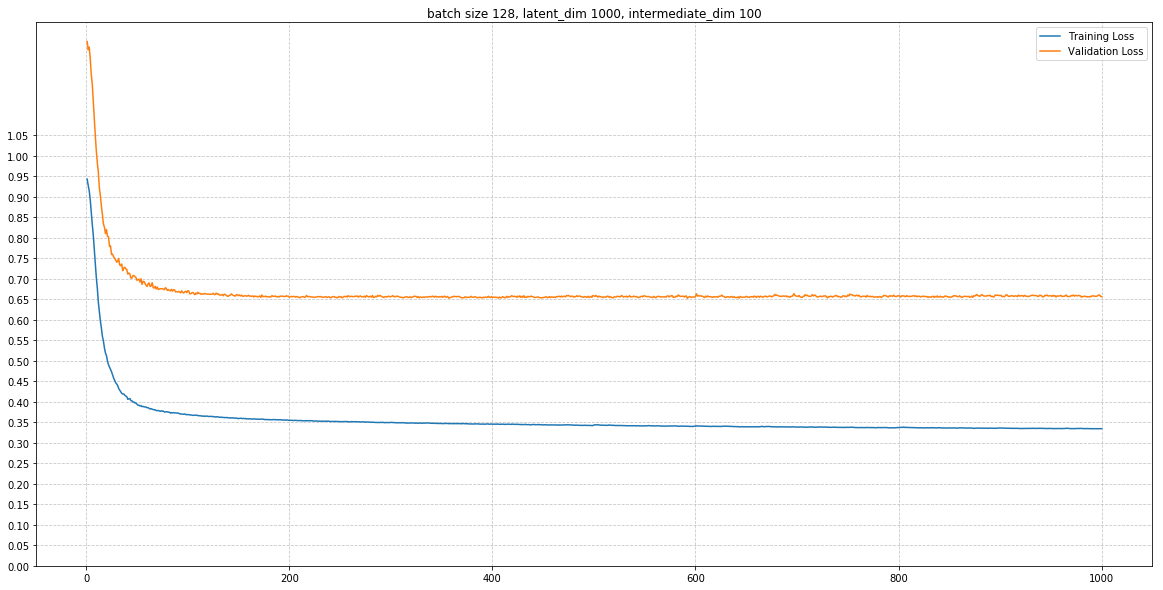

0.33422346292030686 0.6523673039087108
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.40463572303524287


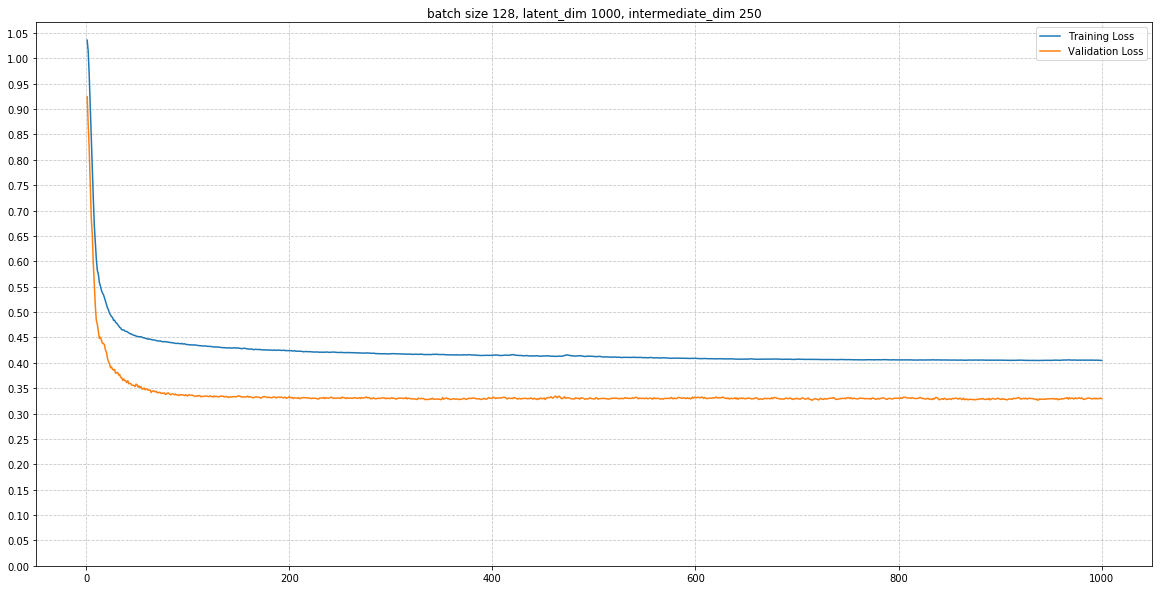

0.40463572303524287 0.3262218732229421
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.4063614815368248


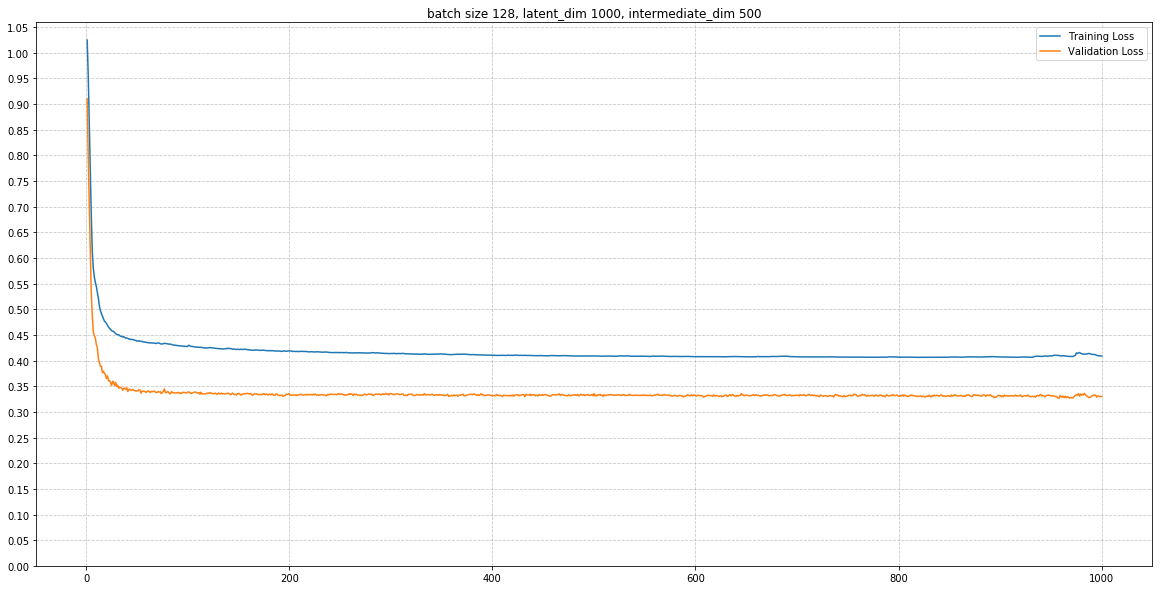

0.4063614815368248 0.3264894415165337


ResourceExhaustedError: OOM when allocating tensor with shape[1000,1000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_59/Adam/gradients/lstm_179/while/MatMul_6_grad/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [13]:
    # Normalization:

    control_data -= mean
    std = control_data.std(axis=0)
    control_data /= std
    pre_data -= mean
    pre_data /= std
    post_data -= mean
    post_data /= std


    # Run the model #

    input_dim = len(_vars)  # vars
    timesteps = NR_VISITS  # visits
    batch_size =   128 # 
    epsilon_std = 1.  #
    latent_dim = 1000  #
    epochs = 1000  #
    intermediate_dim = 250  #
    beta = 0 # Param for KL loss
    
    
   # vae, enc, gen = create_vae(input_dim, timesteps, batch_size, intermediate_dim, latent_dim, epsilon_std, beta)
   # np.random.shuffle(control_data)
   # history = vae.fit(control_data, control_data, epochs=epochs, validation_split=0.20, batch_size=batch_size, verbose=2)
   # preds = vae.predict(control_data, batch_size=batch_size)
   # plot_loss(batch_size, latent_dim, intermediate_dim)
    
    
    b_list=[32,64,128]
    l_list=[100,250,500,1000]
    i_list=[50,100, 250,500,1000]
    vals= np.zeros(shape=(len(b_list),len(l_list),len(i_list),2))
    for index1,batch_size in enumerate(b_list):
        for index2,latent_dim in enumerate(l_list):
            for index3,intermediate_dim in enumerate(i_list):
                vae, enc, gen = create_vae(input_dim, timesteps, batch_size, intermediate_dim, latent_dim, epsilon_std, beta)
                np.random.shuffle(control_data)
                history = vae.fit(control_data, control_data, epochs=epochs, validation_split=0.2, batch_size=batch_size, verbose=0)
                preds = vae.predict(control_data, batch_size=batch_size)
                print("[plotting...]")
                print("x: %s, preds: %s" % (control_data.shape, preds.shape))
                (min_l, min_v) = plot_loss(batch_size, latent_dim, intermediate_dim)
                vals[index1,index2,index3,0] = min_l
                print(min_l, min_v)
                vals[index1,index2,index3,1] = min_v if min_v > min_l else min_v * 1000

    best = np.where(vals == np.amin(vals))
    
    vae, enc, gen = create_vae(input_dim, timesteps, b_list[best[0]],i_list[best[1]], l_list[best[2]], epsilon_std, beta)
    np.random.shuffle(control_data)
    history = vae.fit(control_data, control_data, epochs=epochs, validation_split=0.2, batch_size=batch_size, verbose=2)
    preds = vae.predict(control_data, batch_size=batch_size)
    print("[plotting...]")
    print("x: %s, preds: %s" % (control_data.shape, preds.shape))
    (min_l, min_v) = plot_loss(batch_size, latent_dim, intermediate_dim)
    
                
    
    

batch = 128, latent = 250, intermediate = 100
Prev Min ->  0.35977692349218227
[plotting...]
x: (708, 4, 5), preds: (708, 4, 5)

 Min ->  0.37687808391062194


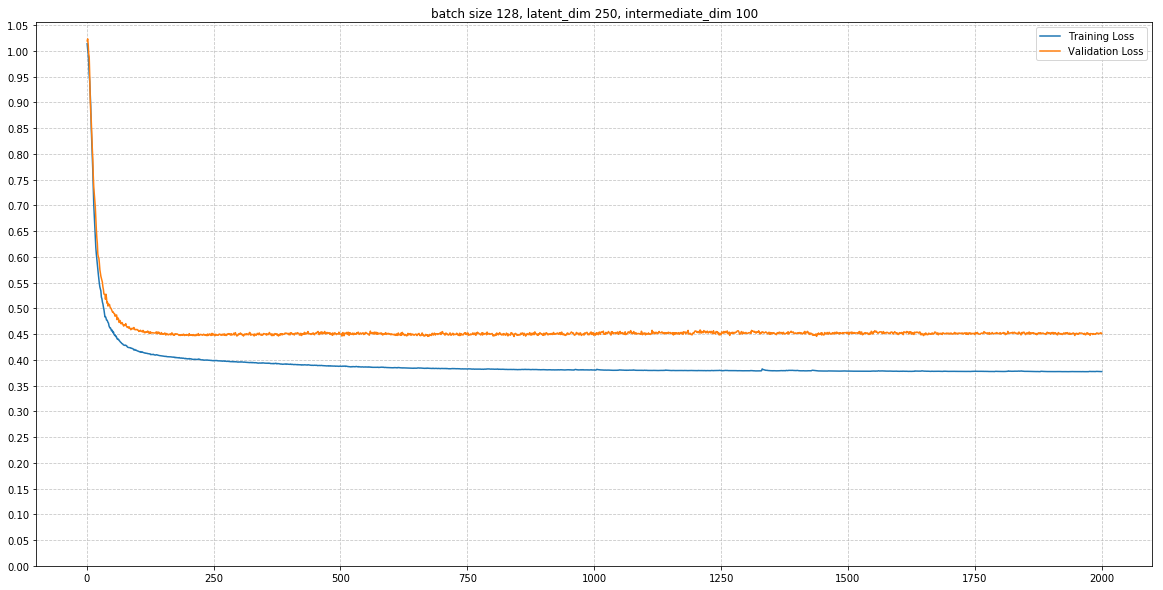

In [33]:
    #control_data -= mean
    #std = control_data.std(axis=0)
    #control_data /= std
    #pre_data -= mean
    #pre_data /= std
    #post_data -= mean
    #post_data /= std
    
    vals[2,3,4,0]=1000
    vals[2,3,4,1]
    #print(vals[])
    best = np.where(vals == np.amin(vals))
    print('batch = %d, latent = %d, intermediate = %d' % (b_list[int(best[0])], l_list[int(best[1])], i_list[int(best[2])]) )
    batch_size = b_list[int(best[0])]
    intermediate_dim=i_list[int(best[2])]
    latent_dim=l_list[int(best[1])]
    epochs=2000
    print("Prev Min ->  0.35977692349218227")
    vae, enc, gen = create_vae(input_dim, timesteps, batch_size,intermediate_dim, latent_dim, epsilon_std, beta)
    np.random.shuffle(control_data)
    history = vae.fit(control_data, control_data, epochs=epochs, validation_split=0.2, batch_size=batch_size, verbose=0)
    preds = vae.predict(control_data, batch_size=batch_size)
    print("[plotting...]")
    print("x: %s, preds: %s" % (control_data.shape, preds.shape))
    (min_l, min_v) = plot_loss(batch_size, latent_dim, intermediate_dim)

In [38]:
    batch_size = 128
    intermediate_dim=1000
    latent_dim=1000
    epochs=1000
    K.clear_session()
    
    vae, enc, gen = create_vae(input_dim, timesteps, batch_size,intermediate_dim, latent_dim, epsilon_std, beta)
    np.random.shuffle(control_data)
    history = vae.fit(control_data, control_data, epochs=epochs, validation_split=0.2, batch_size=batch_size, verbose=0)
    preds = vae.predict(control_data, batch_size=batch_size)
    print("[plotting...]")
    print("x: %s, preds: %s" % (control_data.shape, preds.shape))
    (min_l, min_v) = plot_loss(batch_size, latent_dim, intermediate_dim)

FailedPreconditionError: Failed to allocate scratch buffer for device 0
	 [[{{node _SOURCE}}]]
	 [[node IsVariableInitialized_46 (defined at /home/miguel/miniconda3/envs/tf36/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:199) ]]

# Prediction plots

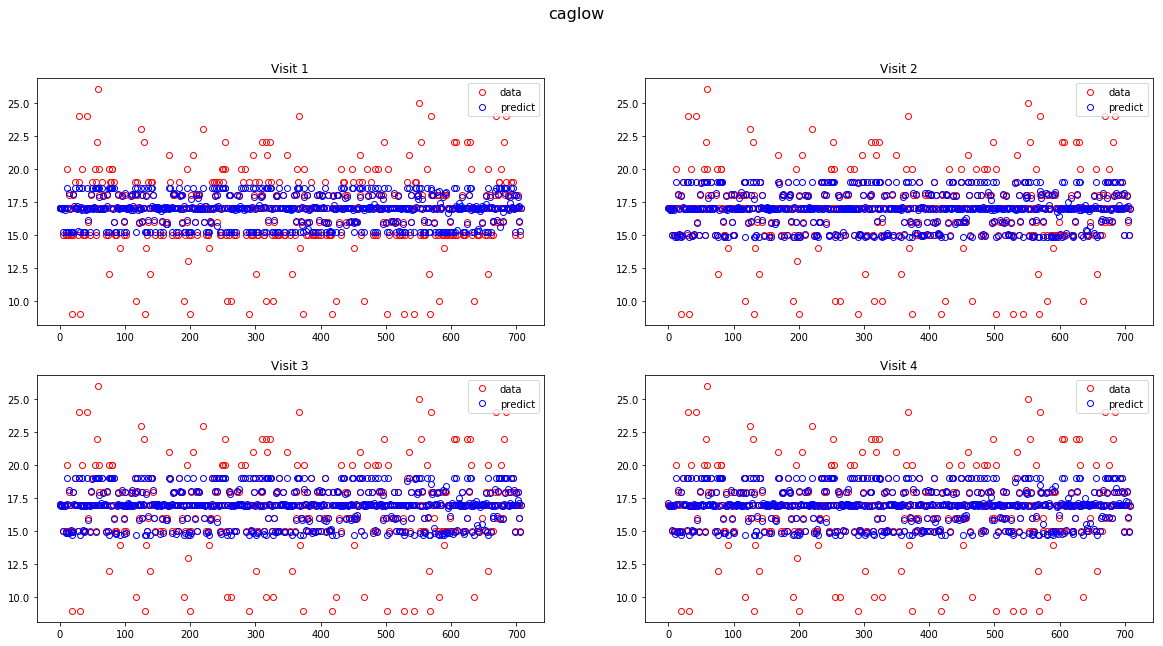

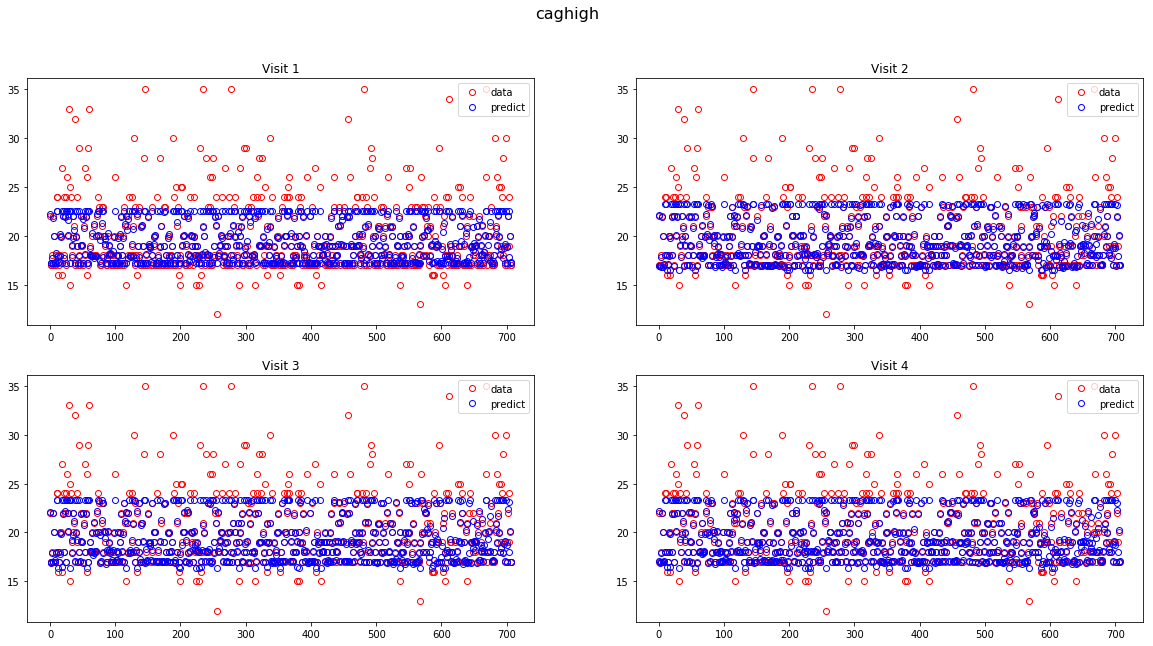

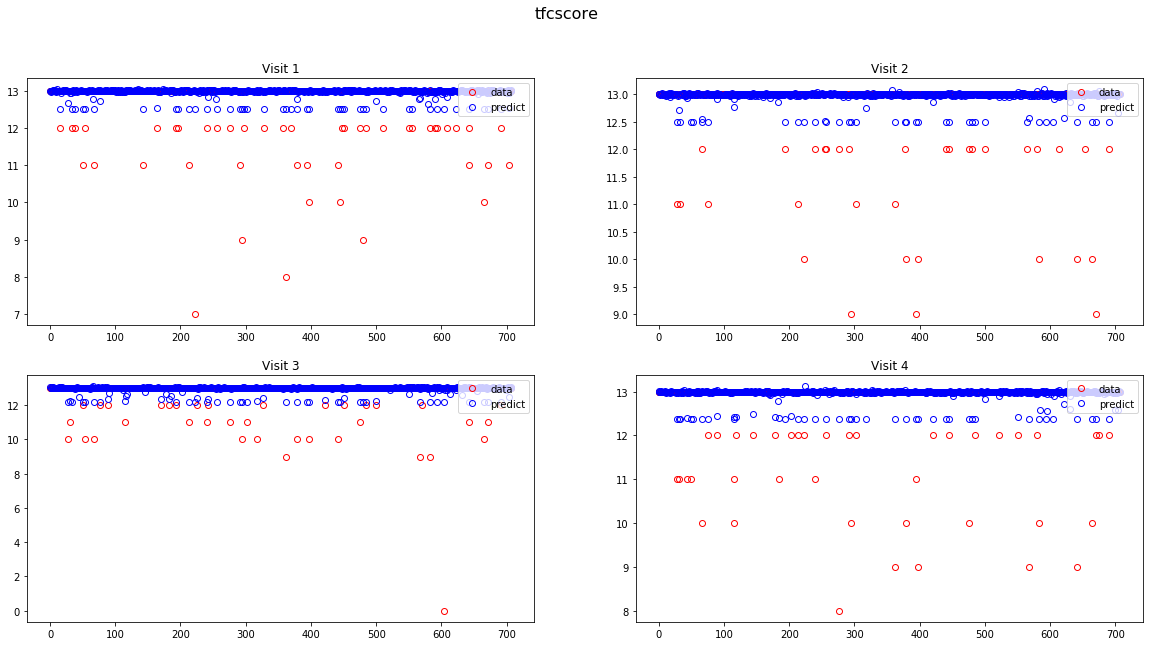

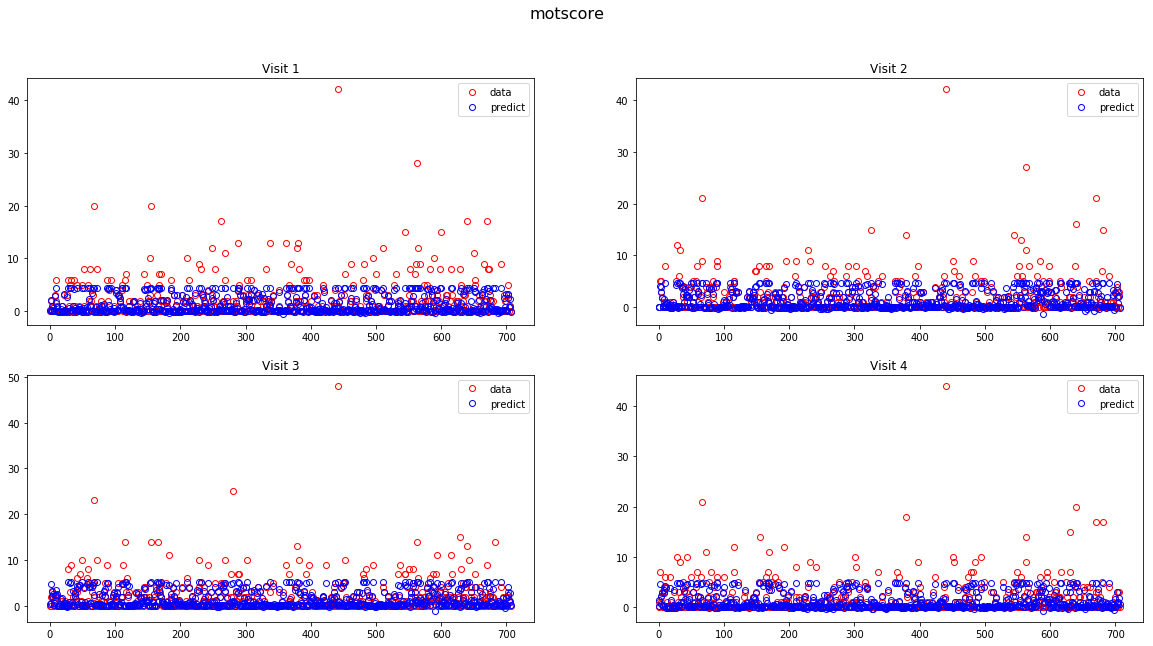

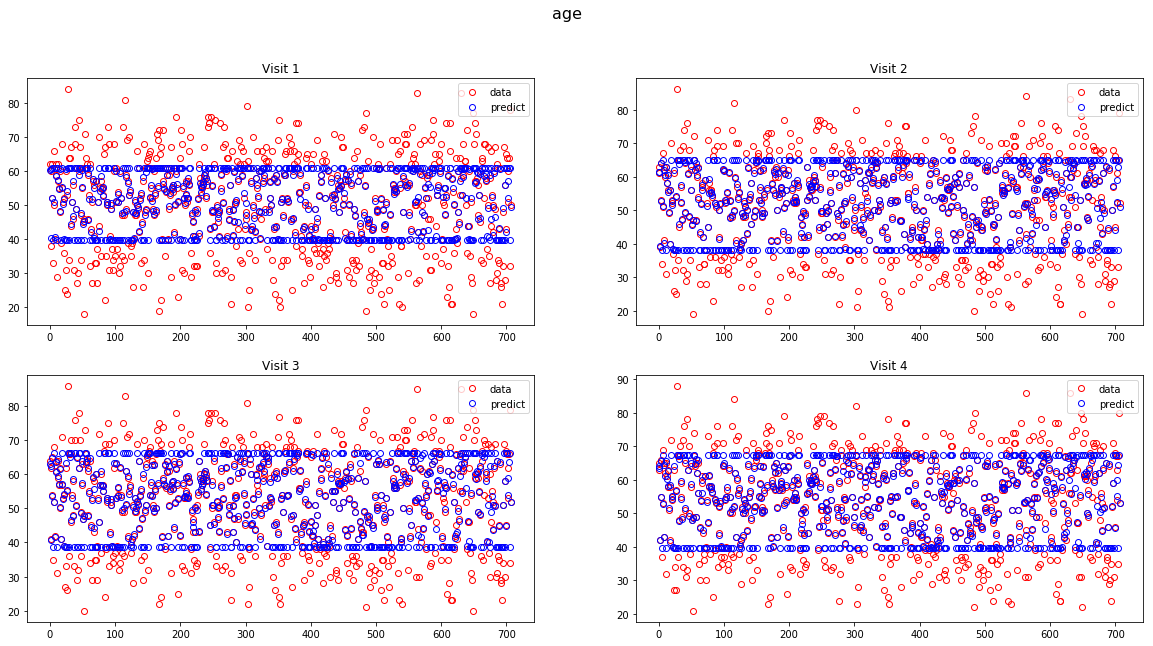

In [27]:
        # Denormalization
        
        control_data *= std
        control_data += mean
        preds *= std
        preds += mean
        
        generate_pred_plots()

In [28]:
print(enc.predict(pre_data).shape)
print(enc.predict(post_data).shape)


(576, 250)
(1885, 250)


In [29]:
vae.predict(pre_data).shape

(576, 4, 5)